# Diabetes Prescreening from Lifestyle and Medical Records (Classification problem)

This notebook performs an EDA of Diabetes Prescreening dataset from CDC. The dataset is taken from [UCI repository](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators).

### About the dataset

The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The research is funded by CDC to better understand the relationship between lifestyle and diabetes in the US. There are 253,680 participants in this study.

The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy.

**Variable table**
- ID: Patient ID   
 
Medical examinations:
- HighBP (Binary): 0 = no high BP; 1 = high BP (systolic: > 130 mmHg, and/or diastolic: > 80 mmHg)
- HighChol (Binary): 0 = no high cholesterol; 1 = high cholesterol (total: > 200 mg/dl)   
- CholCheck (Binary): 0 = no; 1 = yes cholesterol check in 5 years   
- BMI (Integer): weight / (height)^2
- Stroke (Binary): (Ever told) you had a stroke. 0 = no 1 = yes 
- HeartDiseaseorAttack (Binary): coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes

Lifestyle:
- Smoker (Binary): Have you smoked at least 100 cigarettes in your entire life? [5 packs = 100 cigarettes] 0 = no 1 = yes
- PhysActivity (Binary): physical activity in past 30 days - not including job 0 = no 1 = yes
- Fruits (Binary): Consume Fruit 1 or more times per day 0 = no 1 = yes
- Veggies (Binary): Consume Vegetables 1 or more times per day 0 = no 1 = yes
- HvyAlcoholConsump (Binary): Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes
- AnyHealthcare (Binary): Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes
- NoDocbcCost (Binary): Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes
- GenHlth (Integer): Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor
- MentHlth (Integer): Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days	
- PhysHlth (Integer): Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days
- DiffWalk (Binary): Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes

Demographic:
- Sex (Binary): 0 = female 1 = male
- Age (Integer): 13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older
- Education (Integer): Education level (EDUCA see codebook) scale 1-6 1 = Never attended school or only kindergarten 2 = Grades 1 through 8 (Elementary) 3 = Grades 9 through 11 (Some high school) 4 = Grade 12 or GED (High school graduate) 5 = College 1 year to 3 years (Some college or technical school) 6 = College 4 years or more (College graduate)
- Income (Integer): Income scale (INCOME2 see codebook) scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or more

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from ucimlrepo import fetch_ucirepo 
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mutual_info_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, confusion_matrix, classification_report, recall_score

from sklearn.metrics import f1_score, roc_auc_score
from scipy import stats
from collections import Counter

from sklearn.linear_model import LogisticRegression

import joblib
import os

RSEED = 42

## Loading the dataset

In [2]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
print(cdc_diabetes_health_indicators.metadata) 
  
# variable information 
print(cdc_diabetes_health_indicators.variables) 


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [3]:
X.head().T

,0,1,2,3,4
HighBP,1,0,1,1,1
HighChol,1,0,1,0,1
CholCheck,1,0,1,1,1
BMI,40,25,28,27,24
Smoker,1,1,0,0,0
Stroke,0,0,0,0,0
HeartDiseaseorAttack,0,0,0,0,0
PhysActivity,0,1,0,1,1
Fruits,0,0,1,1,1
Veggies,1,0,0,1,1


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

In [5]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0
Veggies,253680.0,0.811420,0.391175,0.0,1.0,1.0,1.0,1.0


In [6]:
y.nunique()

Diabetes_binary    2
dtype: int64

## Feature engineering

In [7]:
X.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [8]:
# Check for Binary Var out-of-range
integer = ['BMI','GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
binary = [i for i in X.columns if i not in integer]

In [9]:
pd.DataFrame({
    'N-Unique' : X[binary].nunique(), 
    'Min' : X[binary].min(), 
    'Max' : X[binary].max()
    })

# Nothing wrong with the binary variable

,N-Unique,Min,Max
HighBP,2,0,1
HighChol,2,0,1
CholCheck,2,0,1
Smoker,2,0,1
Stroke,2,0,1
HeartDiseaseorAttack,2,0,1
PhysActivity,2,0,1
Fruits,2,0,1
Veggies,2,0,1
HvyAlcoholConsump,2,0,1


In [10]:
X.isnull().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

                0
BMI             0
GenHlth         0
MentHlth   175680
PhysHlth   160052
Age             0
Education       0
Income          0


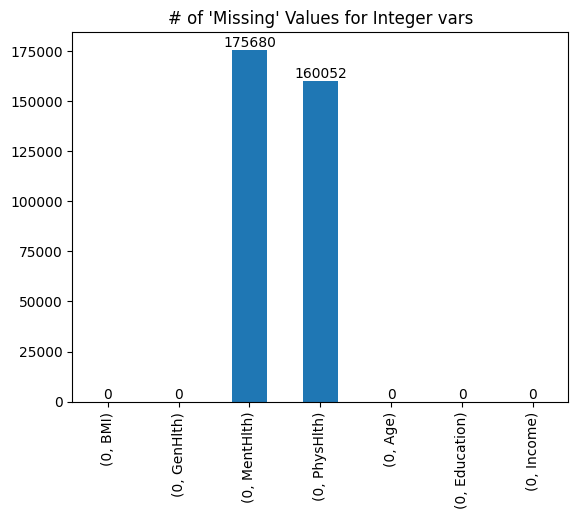

In [11]:
# It seems that all fields has been filed, but some data points are out-of-range.
# Most probably, the 'missing' value is 0 for integer variable.

missing_value = {}
for i in integer:
    missing_value[i] = (X[i] == 0).sum()

missing_value = pd.DataFrame.from_dict(missing_value, orient='index')
print(missing_value)

# Step 2: creating the plot
ax = missing_value.unstack().plot(kind='bar', stacked=True)
ax.set_title("# of 'Missing' Values for Integer vars")
ax.bar_label(ax.containers[0])

plt.show()

In this case, both columns have missing values more than 50% from 253,680 samples. Even with imputation, this columns become not reliable for the classification task.

In [12]:
# Drop the columns
X.drop(['MentHlth','PhysHlth'], axis=1, inplace=True)
integer = ['BMI','GenHlth', 'Age', 'Education', 'Income']

C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_8160\3155099050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['MentHlth','PhysHlth'], axis=1, inplace=True)


In [13]:
# Train-test split
test = 0.2      # adjustable
val = 0.33

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test, random_state=RSEED, stratify=y)
X_traina, X_val, y_traina, y_val = train_test_split(X_train_full, y_train_full, test_size=val, random_state=RSEED, stratify=y_train_full)

In [14]:
# Overall data
print("Overall Data")
print("-"*50)
print(f"Diabetes patients: {y.squeeze().sum():,}")
print(f"Total patients : {len(y.squeeze()):,}")
print(f'% Diabetes :{(y.squeeze().sum()/len(y.squeeze()))*100:,.2f} %')
print("="*50)

# Train data only
print("Train Data Only")
print("-"*50)
print(f"Diabetes patients: {y_train_full.squeeze().sum():,}")
print(f"Total patients : {len(y_train_full.squeeze()):,}")
print(f'% Diabetes :{(y_train_full.squeeze().sum()/len(y_train_full.squeeze()))*100:,.2f} %')

Overall Data
--------------------------------------------------
Diabetes patients: 35,346
Total patients : 253,680
% Diabetes :13.93 %
Train Data Only
--------------------------------------------------
Diabetes patients: 28,277
Total patients : 202,944
% Diabetes :13.93 %


It seems that the dataset is imbalanced (only ~13% of target class 1). Therefore, we will  over-sample the instances from the minority classes (1) only in the training set. We'll use **ADASYN** because it focuses more on hard-to-learn minority samples near decision boundary.

In [15]:
# X_resampled_ADASYN, y_resampled_ADASYN
X_train, y_train = ADASYN().fit_resample(X_traina, y_traina)

In [16]:
X_train.iloc[:, 13]

0         1
1         1
2         1
3         3
4         3
         ..
229828    2
229829    2
229830    2
229831    2
229832    2
Name: GenHlth, Length: 229833, dtype: int64

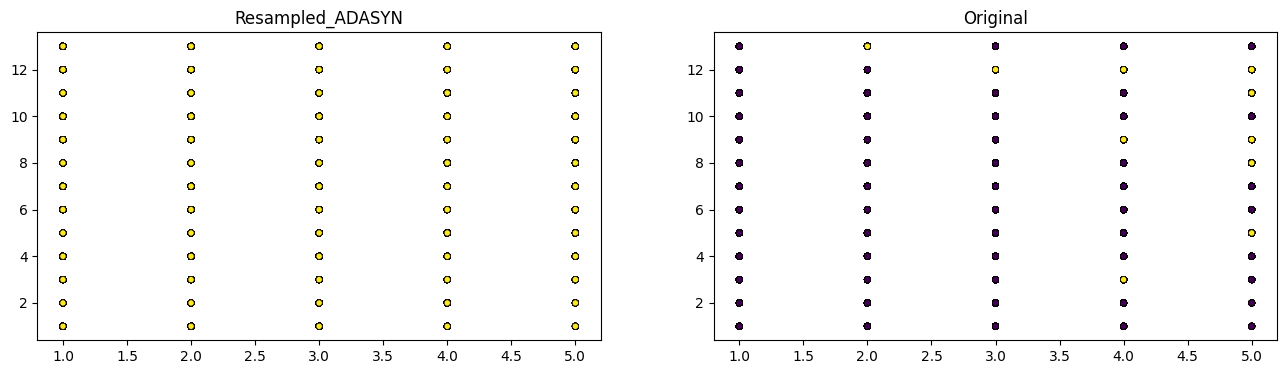

In [17]:
# X-axis = GenHlth (index=13)
# Y-axis = Age (index=16)

fig, ax = plt.subplots(1, 2, figsize=[16, 4])
ax[0].scatter(X_train.iloc[:, 13], X_train.iloc[:, 16], c=np.ravel(y_train), s=20, linewidth=0.5, edgecolor='black')
ax[1].scatter(X_traina.iloc[:, 13], X_traina.iloc[:, 16], c=np.ravel(y_traina), s=20, linewidth=0.5, edgecolor='black')
ax[0].set_title("Resampled_ADASYN")
ax[1].set_title("Original")

plt.show()

## EDA + Feature Importance

In [18]:
# There are 1,572 people claiming that they haven't check cholesterol in last 5 years, but their cholesterol is considerably high

X_train_full[X_train_full['CholCheck']==0]['HighChol'].sum()

np.int64(1572)

#### For Integer features

In [19]:
# Quick stats for numerical variables
X_train_full[integer].describe().T 

,count,mean,std,min,25%,50%,75%,max
BMI,202944.0,28.377961,6.598293,12.0,24.0,27.0,31.0,98.0
GenHlth,202944.0,2.511836,1.068378,1.0,2.0,2.0,3.0,5.0
Age,202944.0,8.032827,3.051388,1.0,6.0,8.0,10.0,13.0
Education,202944.0,5.049925,0.986384,1.0,4.0,5.0,6.0,6.0
Income,202944.0,6.050832,2.072661,1.0,5.0,7.0,8.0,8.0


In [20]:
# Calculate correlation matrix
plt.figure(figsize=(20,12))
cor = X_train_full[integer].corrwith(y_train_full['Diabetes_binary']).sort_values(ascending=False).to_frame(name='correlation')
cor

# There is no single feature that is more dominant than the other integer variables.

,correlation
GenHlth,0.293909
BMI,0.219193
Age,0.177213
Education,-0.123681
Income,-0.164190


<Figure size 2000x1200 with 0 Axes>

#### For Binary features

*Compute risk ratios or difference in means for binary feature: it highlights which binary variables increase or decrease risk.*
- mean: prevalences; ~1: high probability
- risk ratio: how much more (or less) likely a certain group is to diabetes compared to the overall population

Risk ratio= P(target=1∣category) / P(target=1 overall) <br>
Meaning:
- '> 1: Higher risk than average -> this category is associated with more likelihood of target=1. Example: If risk_ratio = 1.5 -> 50% higher chance of target=1 than overall
- < 1: Lower risk than average -> this category is associated with less likelihood of target=1. Example: If risk_ratio = 0.7 -> 30% lower chance of target=1 than overall.

In [21]:
# For binary variables, calculating mean gives prevalence
X_train_full[binary].mean().sort_values(ascending=False)

CholCheck               0.962418
AnyHealthcare           0.951149
Veggies                 0.811426
PhysActivity            0.756992
Fruits                  0.634426
Smoker                  0.442861
Sex                     0.441013
HighBP                  0.428995
HighChol                0.424304
DiffWalk                0.168160
HeartDiseaseorAttack    0.094248
NoDocbcCost             0.084624
HvyAlcoholConsump       0.055730
Stroke                  0.040405
dtype: float64

In [22]:
def binary_feature_risk(X, y, binary_features):
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
        
    global_mean = y.mean()
    results = {}
    
    for col in binary_features:
        grouped = y.groupby(X[col]).mean()
        risk_ratio = grouped / global_mean
        df_temp = pd.DataFrame({
            'mean': grouped.values,
            'risk_ratio': risk_ratio.values
        }, index=grouped.index)
        results[col] = df_temp
        
    return results

risk_tables = binary_feature_risk(X_train_full, y_train_full, binary)

for col, table in risk_tables.items():
    print(f'Feature: {col}')
    display(table)



Feature: HighBP


,mean,risk_ratio
HighBP,,
0,0.060268,0.432545
1,0.244573,1.755299


Feature: HighChol


,mean,risk_ratio
HighChol,,
0,0.07966,0.57172
1,0.22030,1.58109


Feature: CholCheck


,mean,risk_ratio
CholCheck,,
0,0.024780,0.177849
1,0.143807,1.032104


Feature: Smoker


,mean,risk_ratio
Smoker,,
0,0.120388,0.864023
1,0.163169,1.171066


Feature: Stroke


,mean,risk_ratio
Stroke,,
0,0.131778,0.945771
1,0.318780,2.287887


Feature: HeartDiseaseorAttack


,mean,risk_ratio
HeartDiseaseorAttack,,
0,0.119450,0.857295
1,0.330423,2.371445


Feature: PhysActivity


,mean,risk_ratio
PhysActivity,,
0,0.211408,1.517274
1,0.116197,0.833946


Feature: Fruits


,mean,risk_ratio
Fruits,,
0,0.159157,1.142268
1,0.127912,0.918021


Feature: Veggies


,mean,risk_ratio
Veggies,,
0,0.178913,1.284058
1,0.130136,0.933985


Feature: HvyAlcoholConsump


,mean,risk_ratio
HvyAlcoholConsump,,
0,0.144129,1.034413
1,0.058090,0.416913


Feature: AnyHealthcare


,mean,risk_ratio
AnyHealthcare,,
0,0.114989,0.825275
1,0.140584,1.008974


Feature: NoDocbcCost


,mean,risk_ratio
NoDocbcCost,,
0,0.135926,0.975542
1,0.176197,1.264563


Feature: DiffWalk


,mean,risk_ratio
DiffWalk,,
0,0.105108,0.754359
1,0.308641,2.215118


Feature: Sex


,mean,risk_ratio
Sex,,
0,0.129810,0.931644
1,0.151406,1.086642


Interpretation:
Some features (e.g., Stroke, HeartDiseaseorAttack, DiffWalk) have strong risk ratios (>2), others are weak.

#### Mutual Information

- Mutual info score measures the non-linear dependency between two variables.
- High MI -> the feature contains a lot of information about churn; have high predictive power
- This usually helpful for categorical features.

In [23]:
mi = X_train_full[binary].apply(lambda x: mutual_info_score(x, y_train_full['Diabetes_binary']))
mi.sort_values(ascending=False)

# Mutual information: lower than 10%, no high predictive power

HighBP                  0.035085
DiffWalk                0.020194
HighChol                0.020015
HeartDiseaseorAttack    0.012605
PhysActivity            0.006434
Stroke                  0.004456
CholCheck               0.003051
HvyAlcoholConsump       0.001992
Smoker                  0.001871
Veggies                 0.001438
Fruits                  0.000930
NoDocbcCost             0.000493
Sex                     0.000477
AnyHealthcare           0.000133
dtype: float64

## Training phase

In [24]:
def feature_importances(model, feature_names, model_name="Model"):
    importances = model.feature_importances_

    # Create manual plot with proper feature names
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10,6))
    plt.bar(range(len(feature_importance_df)), feature_importance_df['importance'], align="center")
    plt.xticks(range(len(feature_importance_df)), feature_importance_df['feature'], rotation=45)
    plt.xlabel('Importance (Gain)')
    plt.title(f"{model_name} Feature Importances")
    plt.tight_layout()
    plt.show()

    # Print the values for reference
    print("\nFeature Importance Values:")
    for _, row in feature_importance_df.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

In [25]:
def eval_model(y_true, y_pred, y_proba, model_name="Model"):
    # Metrics

    roc_auc = roc_auc_score(y_true, y_proba)
    report = classification_report(y_true, y_pred)

    print(f"=== {model_name} Evaluation ===")
    print(f"ROC-AUC:  {roc_auc:.3f}")
    print("\nClassification Report:\n", report)

    # Prepare figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    axes[0].set_title("Confusion Matrix")

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    axes[1].plot([0, 1], [0, 1], linestyle="--", color="grey")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("ROC Curve")
    axes[1].legend()

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    axes[2].plot(recall, precision, marker=".")
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].set_title(f"PR Curve (AUC = {pr_auc:.3f})")

    plt.suptitle(f"{model_name} Evaluation Results", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


### Training Random Forest

In [26]:
n_estimators = 200
max_depth = None
class_weight = 'balanced' # because the target is imbalanced

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RSEED, class_weight=class_weight)
rf.fit(X_train, y_train)

c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
# Predictions
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

=== RandomForest Evaluation ===
ROC-AUC:  0.760

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87     57641
           1       0.31      0.48      0.38      9331

    accuracy                           0.78     66972
   macro avg       0.61      0.65      0.62     66972
weighted avg       0.82      0.78      0.80     66972



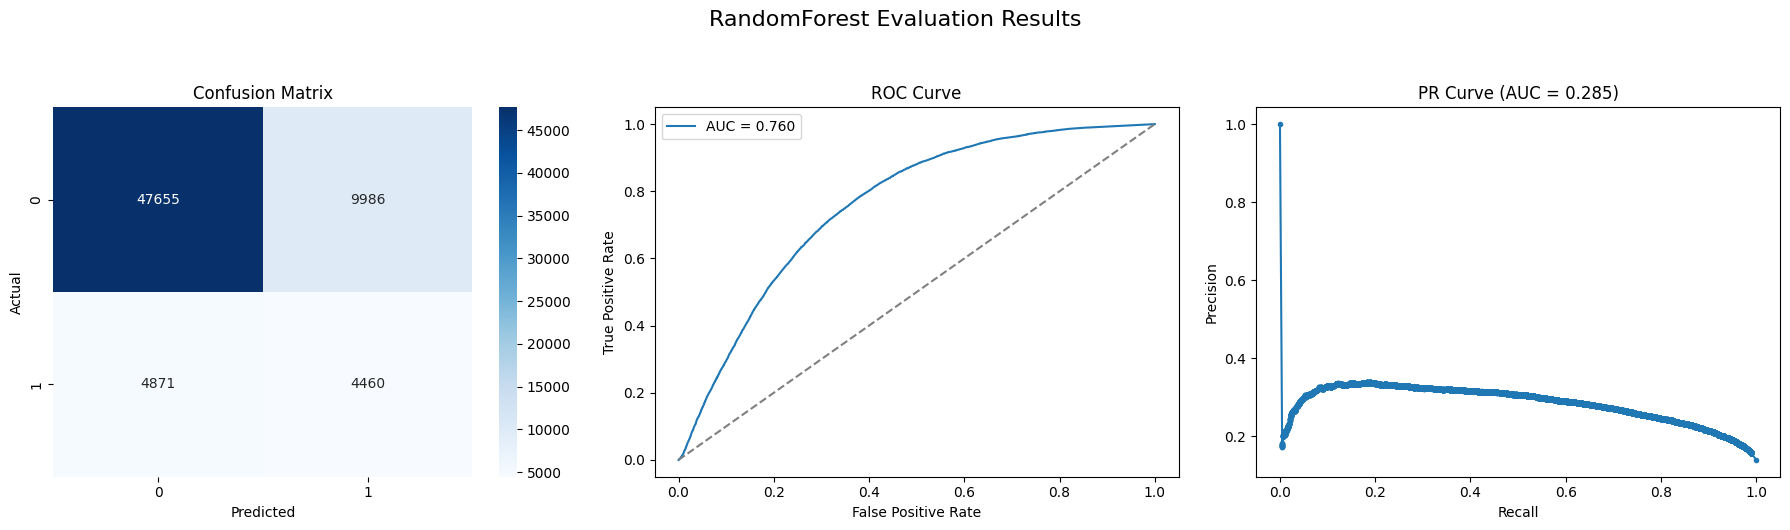

In [28]:
eval_model(y_val, y_pred_rf, y_proba_rf, model_name="RandomForest")

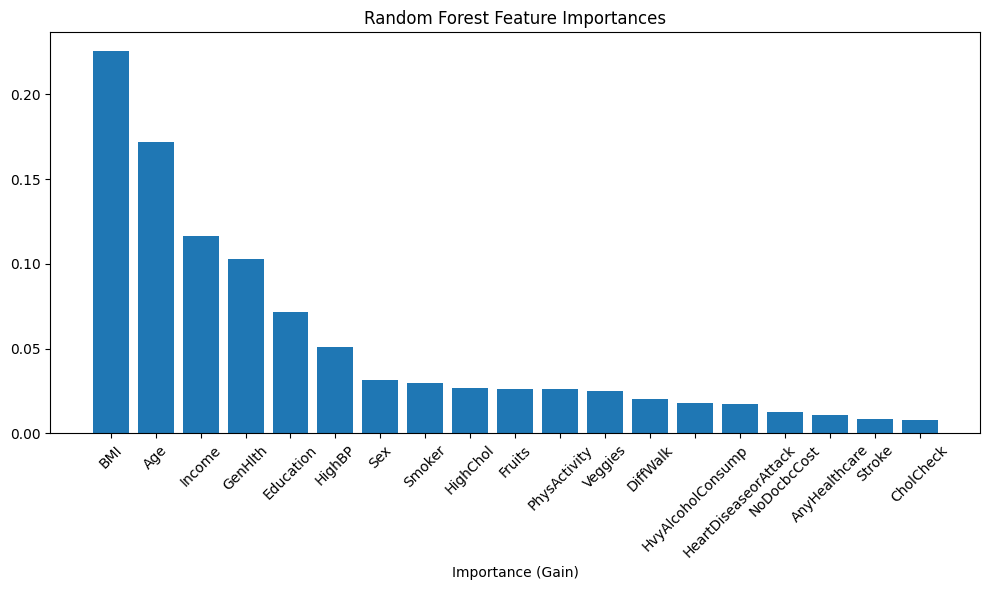


Feature Importance Values:
BMI: 0.2254
Age: 0.1720
Income: 0.1166
GenHlth: 0.1032
Education: 0.0718
HighBP: 0.0509
Sex: 0.0314
Smoker: 0.0296
HighChol: 0.0269
Fruits: 0.0260
PhysActivity: 0.0258
Veggies: 0.0252
DiffWalk: 0.0204
HvyAlcoholConsump: 0.0179
HeartDiseaseorAttack: 0.0171
NoDocbcCost: 0.0127
AnyHealthcare: 0.0105
Stroke: 0.0087
CholCheck: 0.0076


In [29]:
# Model Interpretability
feature_importances(rf, feature_names = X_train_full.columns, model_name="Random Forest")

### Training Logistic regression

In [30]:
lr = LogisticRegression(solver='liblinear', random_state=RSEED, class_weight=class_weight)
lr.fit(X_train, y_train)

c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [31]:
y_proba_lr = lr.predict_proba(X_val)[:, 1]
y_pred_lr = (y_proba_lr > 0.5).astype(int)

=== Logistic Regression Evaluation ===
ROC-AUC:  0.787

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.70      0.80     57641
           1       0.28      0.73      0.41      9331

    accuracy                           0.70     66972
   macro avg       0.61      0.71      0.60     66972
weighted avg       0.85      0.70      0.75     66972



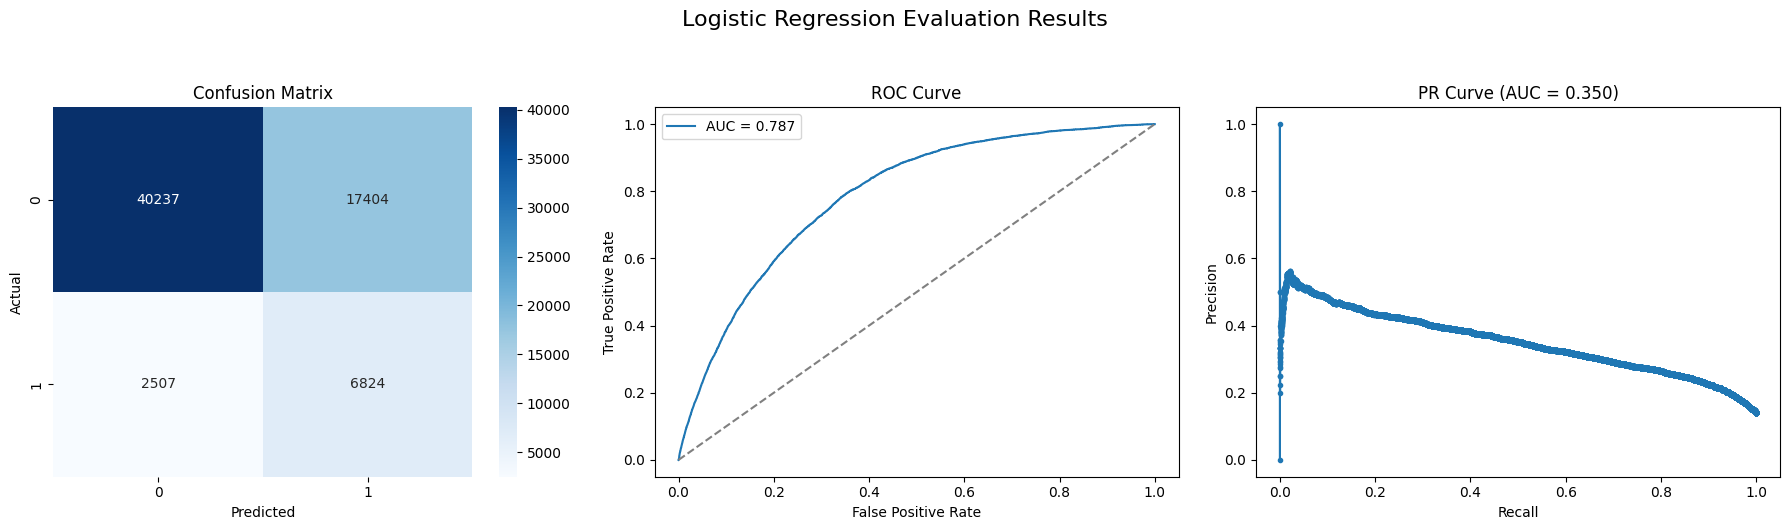

In [32]:
eval_model(y_val, y_pred_lr, y_proba_lr, model_name="Logistic Regression")

Interpretability:
- Coefficient: Positive -> increases log-odds of diabetes; Negative -> decreases it.
- Odds Ratio (exp(coef)): > 1 -> increases risk of diabetes; < 1 -> decreases risk

In [33]:
# Interpretability by extracting coefficients
coefs = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lr.coef_[0],
    "Odds_Ratio": np.exp(lr.coef_[0])
}).sort_values(by="Coefficient", ascending=False)

print(coefs)


                 Feature  Coefficient  Odds_Ratio
2              CholCheck     1.221067    3.390803
0                 HighBP     0.568976    1.766457
13               GenHlth     0.483524    1.621779
1               HighChol     0.353858    1.424554
16                   Age     0.148868    1.160520
3                    BMI     0.062084    1.064051
15                   Sex    -0.022977    0.977285
18                Income    -0.086832    0.916831
6   HeartDiseaseorAttack    -0.128586    0.879338
17             Education    -0.136237    0.872636
9                Veggies    -0.180233    0.835076
11         AnyHealthcare    -0.253659    0.775956
4                 Smoker    -0.295385    0.744245
7           PhysActivity    -0.354136    0.701779
8                 Fruits    -0.371619    0.689617
14              DiffWalk    -0.438461    0.645028
5                 Stroke    -0.663536    0.515027
12           NoDocbcCost    -0.967693    0.379959
10     HvyAlcoholConsump    -2.104649    0.121888


In [34]:
def play_threshold(thresholds,y_proba):
    recs = []
    f1s = []
    roc_aucs = []


    for t in thresholds:
        y_pred = (y_proba > t).astype(int)
        rec = recall_score(y_val, y_pred)
        recs.append(rec)
        f1 = f1_score(y_val, y_pred)
        f1s.append(f1)
        roc_auc = roc_auc_score(y_val, y_pred)
        roc_aucs.append(roc_auc)

        print(f"Threshold={t:.2f} | Recall={rec:.3f} | F1-score={f1:.3f} | ROC_AUC={roc_auc:.3f}")
        
    # Visualization
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, recs, color='black', label='Recall (binary)')
    plt.plot(thresholds, f1s, color='black', label='F-1 score (binary)')
    plt.plot(thresholds, roc_aucs, color='red', label='ROC-AUC (binary)')
    plt.title('Threshold vs Metrics')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.xticks(np.linspace(0, 1, 11))
    plt.legend()
    plt.show()

Threshold=0.10 | Recall=0.988 | F1-score=0.268 | ROC_AUC=0.558
Threshold=0.15 | Recall=0.978 | F1-score=0.289 | ROC_AUC=0.600
Threshold=0.20 | Recall=0.961 | F1-score=0.309 | ROC_AUC=0.635
Threshold=0.25 | Recall=0.944 | F1-score=0.330 | ROC_AUC=0.666
Threshold=0.30 | Recall=0.918 | F1-score=0.349 | ROC_AUC=0.689
Threshold=0.35 | Recall=0.887 | F1-score=0.369 | ROC_AUC=0.707
Threshold=0.40 | Recall=0.845 | F1-score=0.385 | ROC_AUC=0.716
Threshold=0.45 | Recall=0.796 | F1-score=0.399 | ROC_AUC=0.720
Threshold=0.50 | Recall=0.731 | F1-score=0.407 | ROC_AUC=0.715
Threshold=0.55 | Recall=0.669 | F1-score=0.416 | ROC_AUC=0.709
Threshold=0.60 | Recall=0.597 | F1-score=0.419 | ROC_AUC=0.697
Threshold=0.65 | Recall=0.516 | F1-score=0.414 | ROC_AUC=0.679
Threshold=0.70 | Recall=0.428 | F1-score=0.399 | ROC_AUC=0.656
Threshold=0.75 | Recall=0.332 | F1-score=0.362 | ROC_AUC=0.625
Threshold=0.80 | Recall=0.235 | F1-score=0.303 | ROC_AUC=0.592
Threshold=0.85 | Recall=0.141 | F1-score=0.216 | ROC_AU

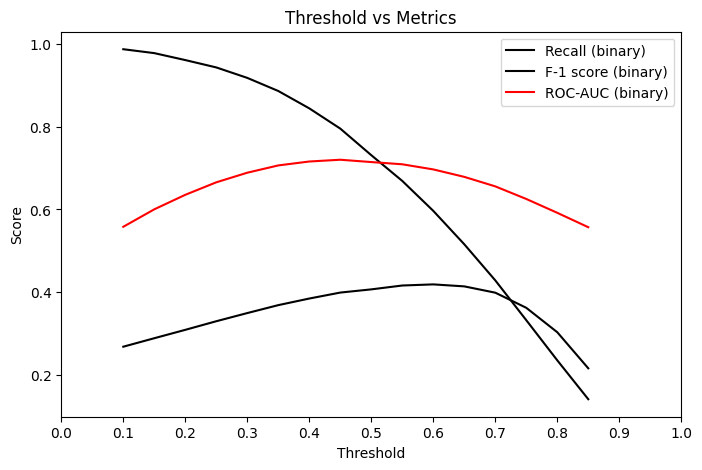

In [35]:
# Play around threshold
thresholds = np.arange(0.1, 0.9, 0.05)
play_threshold(thresholds, y_proba_lr)

### Training LightGBM

In [36]:
class_weight = 'balanced' # because the target is imbalanced

lgbm = lgb.LGBMClassifier(random_state=RSEED, class_weight=class_weight)
lgbm.fit(X_train, y_train)

c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 112807, number of negative: 117026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 229833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [37]:
y_proba_lgbm = lgbm.predict_proba(X_val)[:, 1]
y_pred_lgbm = (y_proba_lgbm > 0.5).astype(int)

=== LightGBM Evaluation ===
ROC-AUC:  0.790

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.67      0.79     57641
           1       0.28      0.76      0.40      9331

    accuracy                           0.69     66972
   macro avg       0.61      0.72      0.60     66972
weighted avg       0.85      0.69      0.73     66972



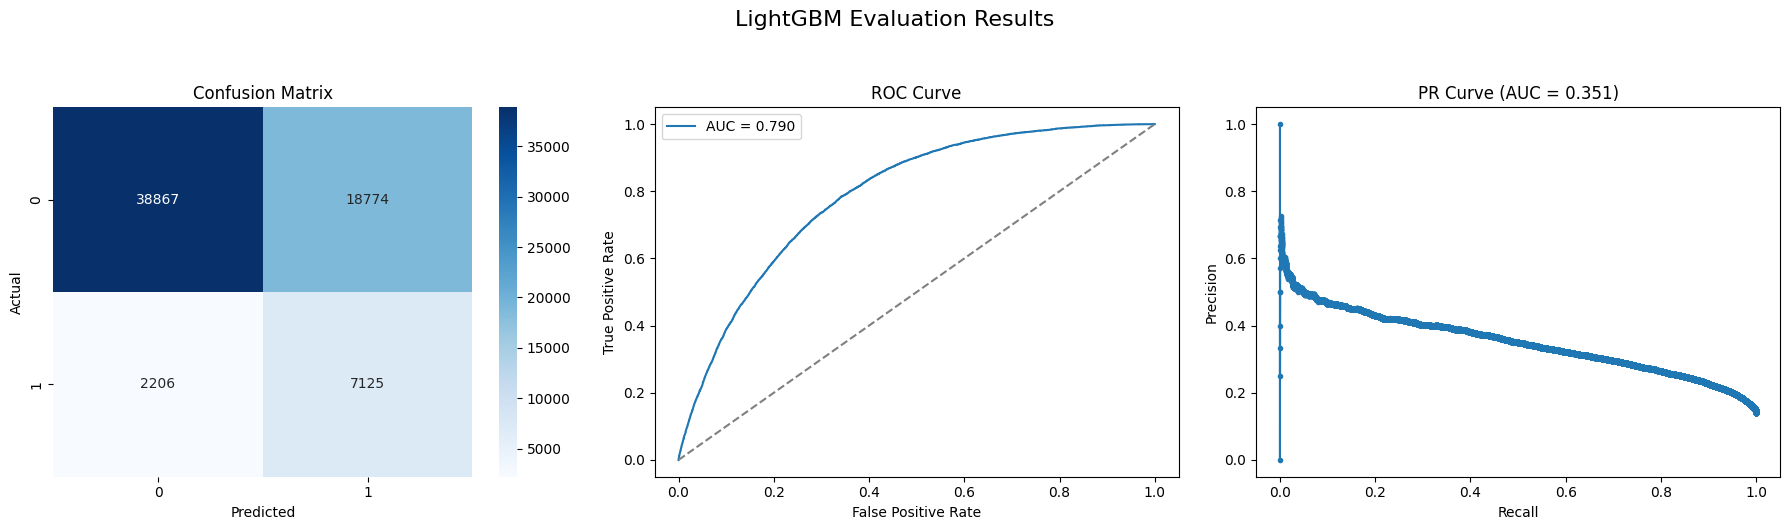

In [38]:
eval_model(y_val, y_pred_lgbm, y_proba_lgbm, model_name="LightGBM")

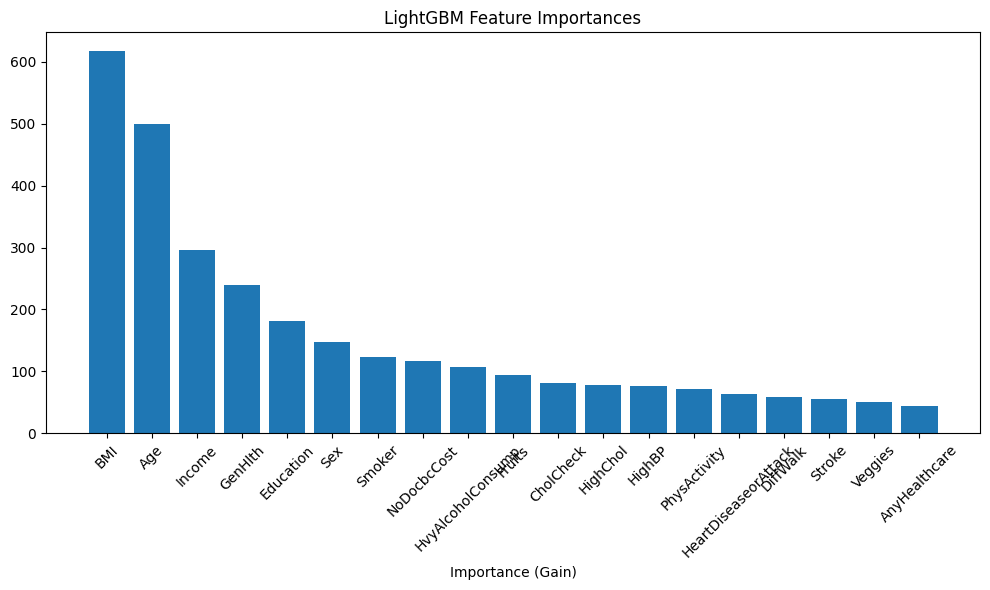


Feature Importance Values:
BMI: 617.0000
Age: 499.0000
Income: 296.0000
GenHlth: 239.0000
Education: 181.0000
Sex: 148.0000
Smoker: 123.0000
NoDocbcCost: 116.0000
HvyAlcoholConsump: 107.0000
Fruits: 94.0000
CholCheck: 81.0000
HighChol: 78.0000
HighBP: 77.0000
PhysActivity: 72.0000
HeartDiseaseorAttack: 63.0000
DiffWalk: 59.0000
Stroke: 55.0000
Veggies: 51.0000
AnyHealthcare: 44.0000


In [39]:
# Model Interpretability
feature_importances(lgbm, feature_names = X_train_full.columns, model_name="LightGBM")

### Statistical test

Compare the model based on better ROC_AUC-score. It measures how well the model ranks positives vs negatives across all thresholds. Moreover, it is more stable than F1 across thresholds.

In model selection stage, we care about how well the model separates classes overall. Therefore, we want to evaluate discrimination ability regardless of threshold.

In [40]:
def compare_models_prf(y_true, pred_proba1, pred_proba2, model1_name, model2_name, threshold=0.5):
    """
    Compare two models and perform a paired t-test on the squared errors of predicted probabilities.
    Metrics to be used:
    - F1-score at a given threshold
    - PR-AUC
    - ROC-AUC
    """
    
    # Convert probabilities to binary predictions using threshold
    pred1 = (pred_proba1 >= threshold).astype(int)
    pred2 = (pred_proba2 >= threshold).astype(int)
    
    # F1-score
    f1_1 = f1_score(y_true, pred1)
    f1_2 = f1_score(y_true, pred2)
    
    # PR-AUC
    precision1, recall1, _ = precision_recall_curve(y_true, pred_proba1)
    pr_auc1 = auc(recall1, precision1)
    
    precision2, recall2, _ = precision_recall_curve(y_true, pred_proba2)
    pr_auc2 = auc(recall2, precision2)
    
    # ROC-AUC
    roc_auc1 = roc_auc_score(y_true, pred_proba1)
    roc_auc2 = roc_auc_score(y_true, pred_proba2)
    
    # Paired t-test on squared errors of probabilities (optional, numeric comparison)
    se1 = (y_true - pred_proba1) ** 2
    se2 = (y_true - pred_proba2) ** 2
    t_stat, p_value = stats.ttest_rel(se1, se2)
    alpha = 0.05
    is_significant = p_value < alpha
    
    better_model = model1_name if f1_1 > f1_2 else model2_name
    worse_model = model2_name if f1_1 > f1_2 else model1_name
    
    print(f"\n{model1_name} vs {model2_name}:")
    print(f"  F1-score ({threshold=}): {f1_1:.3f} vs {f1_2:.3f}")
    print(f"  PR-AUC: {pr_auc1:.3f} vs {pr_auc2:.3f}")
    print(f"  ROC-AUC: {roc_auc1:.3f} vs {roc_auc2:.3f}")
    print(f"  t-statistic (on squared probs): {t_stat:.4f}, p-value: {p_value:.4f}")
    
    if is_significant:
        print(f"  Result: {better_model} is SIGNIFICANTLY better than {worse_model} (p < {alpha})")
    else:
        print(f"  Result: No significant difference between models (p >= {alpha})")
    
    return {
        'model1': model1_name,
        'model2': model2_name,
        'f1_1': f1_1,
        'f1_2': f1_2,
        'pr_auc1': pr_auc1,
        'pr_auc2': pr_auc2,
        'roc_auc1': roc_auc1,
        'roc_auc2': roc_auc2,
        't_stat': t_stat,
        'p_value': p_value,
        'is_significant': is_significant,
        'better_model': better_model
    }

In [41]:
print("STATISTICAL COMPARISON OF MODELS")
print("="*50)

# Get predictions from all models
rf_predictions = np.ravel(y_pred_rf)
lr_predictions = np.ravel(y_pred_lr)
lgbm_predictions = np.ravel(y_pred_lgbm)
y_val = np.ravel(y_val)

# Compare all pairs
comparison_results = []

# 'Random Forest' vs 'Logistic Regression'
comp1 = compare_models_prf(y_val, rf_predictions, lr_predictions,
                           'Random Forest', 'Logistic Regression')
comparison_results.append(comp1)

# 'Random Forest' vs 'LightGBM'
comp2 = compare_models_prf(y_val, rf_predictions, lgbm_predictions,
                            'Random Forest', 'LightGBM')
comparison_results.append(comp2)

# 'Logistic Regression' vs 'LightGBM'
comp3 = compare_models_prf(y_val, lr_predictions, lgbm_predictions,
                                   'Logistic Regression','LightGBM')
comparison_results.append(comp3)

STATISTICAL COMPARISON OF MODELS

Random Forest vs Logistic Regression:
  F1-score (threshold=0.5): 0.375 vs 0.407
  PR-AUC: 0.430 vs 0.525
  ROC-AUC: 0.652 vs 0.715
  t-statistic (on squared probs): -41.9555, p-value: 0.0000
  Result: Logistic Regression is SIGNIFICANTLY better than Random Forest (p < 0.05)

Random Forest vs LightGBM:
  F1-score (threshold=0.5): 0.375 vs 0.404
  PR-AUC: 0.430 vs 0.536
  ROC-AUC: 0.652 vs 0.719
  t-statistic (on squared probs): -50.9165, p-value: 0.0000
  Result: LightGBM is SIGNIFICANTLY better than Random Forest (p < 0.05)

Logistic Regression vs LightGBM:
  F1-score (threshold=0.5): 0.407 vs 0.404
  PR-AUC: 0.525 vs 0.536
  ROC-AUC: 0.715 vs 0.719
  t-statistic (on squared probs): -13.4660, p-value: 0.0000
  Result: Logistic Regression is SIGNIFICANTLY better than LightGBM (p < 0.05)


### **Conclusion:**

What do the parameters mean?
- F1-score (threshold = 0.5) measures the balance between precision and recall when predicting with default cutoff at 0.5.
- PR-AUC (Precision-Recall AUC) is good for imbalanced datasets, measures performance on positive class.
- ROC-AUC measures separability between classes (higher is better).

Random Forest vs Logistic Regression:
- Logistic Regression has better F1, PR-AUC, and ROC-AUC.
- t-statistic is large negative, p-value is basically 0.
- Conclusion: Logistic Regression is significantly better.

Random Forest vs LightGBM:
- LightGBM has better metrics across the board.
- p-value = 0, so difference is significant.
- Conclusion: LightGBM is significantly better.

Logistic Regression vs LightGBM:
- Metrics are very close (LR slightly better in F1, LightGBM slightly better in PR-AUC & ROC-AUC).
- Yet, the t-test says Logistic Regression is significantly better. It means its probability estimates align more consistently with true outcomes, even though LightGBM had slightly higher raw scores.

**OVERALL, the winner is LOGISTIC REGRESSION**

## Training 3 model with 3 subsets of features

Based on the learning above, it is very obvious that **medical examination features show the higher predictive power compared to other factors.** However, what if we use only the lifestyle and demography feature to classify the patient? How much do the performance degradation we have? How fewer are the ROC_AUC, PR_AUC, F1-score compared to full dataset?

3 subsets of features:
1. Lifestyle only includes ['Sex', 'Age', 'Education', 'Income', 'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk']
2. Medical examinations includes ['Sex', 'Age', 'Education', 'Income', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke', 'HeartDiseaseorAttack']
3. All features combines both approaches.

In [42]:
def model_select(X_train, X_val, y_train, y_val, feature_subset="all"):
    """
    Combine the previous code but allows you to specify which feature subset to use.
    
    Parameters:
    - feature_subset: "all", "lifestyle", "medical"
    """
    
    # Define feature subsets
    sub_both = ['Sex', 'Age', 'Education', 'Income']
    sub_lif = ['Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 
               'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk'] + sub_both
    sub_med = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke', 'HeartDiseaseorAttack'] + sub_both
    sub_all = list(set(sub_lif + sub_med))  # Remove duplicates
    
    # Select the appropriate feature subset
    if feature_subset == "lifestyle":
        features = sub_lif
        X_train_subset = X_train[features]
        X_val_subset = X_val[features]
        print(f"Using LIFESTYLE features ({len(features)} features)")
    elif feature_subset == "medical":
        features = sub_med
        X_train_subset = X_train[features]
        X_val_subset = X_val[features]
        print(f"Using MEDICAL features ({len(features)} features)")
    else:  # "all"
        features = sub_all
        X_train_subset = X_train[features]
        X_val_subset = X_val[features]
        print(f"Using ALL features ({len(features)} features)")
    
    print(f"Features: {features}")
    print("="*80)
    
    # Model parameters
    n_estimators = 200
    max_depth = None
    class_weight = 'balanced'
    
    # 1. RANDOM FOREST
    print("Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                               random_state=RSEED, class_weight=class_weight)
    rf.fit(X_train_subset, y_train)
    
    y_pred_rf = rf.predict(X_val_subset)
    y_proba_rf = rf.predict_proba(X_val_subset)[:, 1]
    
    eval_model(y_val, y_pred_rf, y_proba_rf, model_name="RandomForest")
    feature_importances(rf, features, model_name="Random Forest")
    
    # 2. LOGISTIC REGRESSION
    print("\nTraining Logistic Regression...")
    lr = LogisticRegression(solver='liblinear', random_state=RSEED, class_weight=class_weight)
    lr.fit(X_train_subset, y_train)
    
    y_proba_lr = lr.predict_proba(X_val_subset)[:, 1]
    y_pred_lr = (y_proba_lr > 0.5).astype(int)
    
    eval_model(y_val, y_pred_lr, y_proba_lr, model_name="Logistic Regression")
    
    # Show coefficients
    coefs = pd.DataFrame({
        "Feature": features,
        "Coefficient": lr.coef_[0],
        "Odds_Ratio": np.exp(lr.coef_[0])
    }).sort_values(by="Coefficient", key=abs, ascending=False)
    
    print("Logistic Regression Coefficients (Top 10):")
    print(coefs.head(10))
    
    # 3. LIGHTGBM
    print("\nTraining LightGBM...")
    lgbm = lgb.LGBMClassifier(random_state=RSEED, class_weight=class_weight)
    lgbm.fit(X_train_subset, y_train)
    
    y_proba_lgbm = lgbm.predict_proba(X_val_subset)[:, 1]
    y_pred_lgbm = (y_proba_lgbm > 0.5).astype(int)
    
    eval_model(y_val, y_pred_lgbm, y_proba_lgbm, model_name="LightGBM")
    feature_importances(lgbm, features, model_name="LightGBM")
    
    # Statistical Comparison
    print("\n" + "="*50)
    print("STATISTICAL COMPARISON OF MODELS")
    print("="*50)
    
    # Get predictions from all models (using probabilities for comparison)
    rf_predictions = y_proba_rf
    lr_predictions = y_proba_lr
    lgbm_predictions = y_proba_lgbm
    y_val_flat = np.ravel(y_val)
    
    comparison_results = []
    
    # Random Forest vs Logistic Regression
    comp1 = compare_models_prf(y_val_flat, rf_predictions, lr_predictions,
                              'Random Forest', 'Logistic Regression')
    comparison_results.append(comp1)
    
    # Random Forest vs LightGBM
    comp2 = compare_models_prf(y_val_flat, rf_predictions, lgbm_predictions,
                              'Random Forest', 'LightGBM')
    comparison_results.append(comp2)
    
    # Logistic Regression vs LightGBM
    comp3 = compare_models_prf(y_val_flat, lr_predictions, lgbm_predictions,
                              'Logistic Regression', 'LightGBM')
    comparison_results.append(comp3)
    
    # Summary
    print("\n" + "="*50)
    print("PERFORMANCE SUMMARY")
    print("="*50)
    
    summary_data = {
        'Model': ['Random Forest', 'Logistic Regression', 'LightGBM'],
        'ROC-AUC': [
            roc_auc_score(y_val, y_proba_rf),
            roc_auc_score(y_val, y_proba_lr),
            roc_auc_score(y_val, y_proba_lgbm)
        ],
        'F1-Score': [
            f1_score(y_val, y_pred_rf),
            f1_score(y_val, y_pred_lr),
            f1_score(y_val, y_pred_lgbm)
        ],
        'PR-AUC': [
            average_precision_score(y_val, y_proba_rf),
            average_precision_score(y_val, y_proba_lr),
            average_precision_score(y_val, y_proba_lgbm)
        ]
    }
    
    summary_df = pd.DataFrame(summary_data).round(3)
    print(summary_df)
    
    # Return results for further analysis
    return {
        'feature_subset': feature_subset,
        'features_used': features,
        'models': {'rf': rf, 'lr': lr, 'lgbm': lgbm},
        'predictions': {
            'rf_proba': y_proba_rf, 'rf_pred': y_pred_rf,
            'lr_proba': y_proba_lr, 'lr_pred': y_pred_lr,
            'lgbm_proba': y_proba_lgbm, 'lgbm_pred': y_pred_lgbm
        },
        'comparison_results': comparison_results,
        'summary': summary_df
    }


Using LIFESTYLE features (13 features)
Features: ['Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Training Random Forest...


c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


=== RandomForest Evaluation ===
ROC-AUC:  0.682

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.80     57641
           1       0.23      0.54      0.32      9331

    accuracy                           0.69     66972
   macro avg       0.57      0.62      0.56     66972
weighted avg       0.81      0.69      0.73     66972



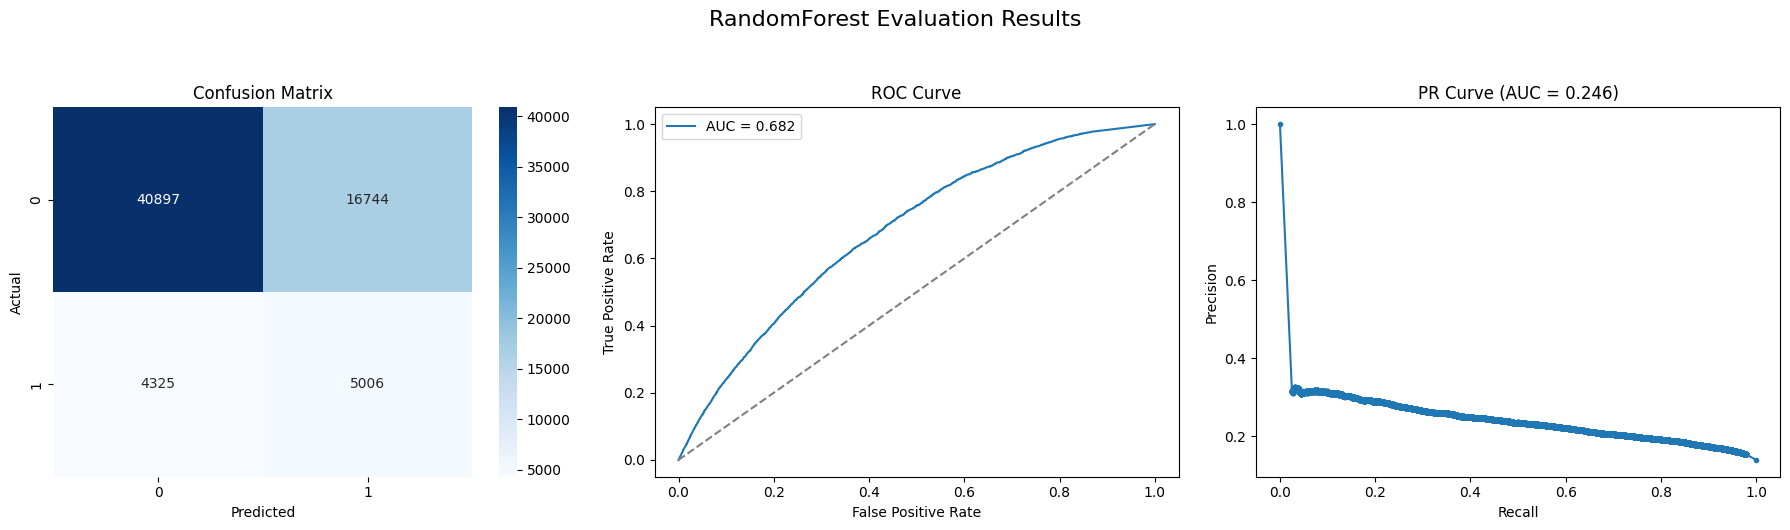

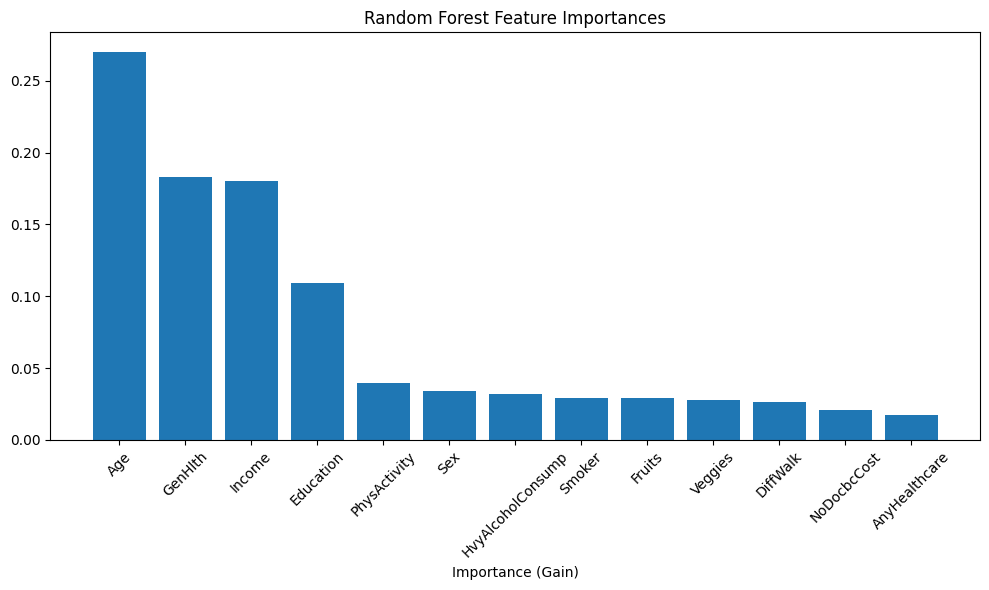


Feature Importance Values:
Age: 0.2702
GenHlth: 0.1833
Income: 0.1802
Education: 0.1095
PhysActivity: 0.0399
Sex: 0.0338
HvyAlcoholConsump: 0.0318
Smoker: 0.0293
Fruits: 0.0293
Veggies: 0.0277
DiffWalk: 0.0267
NoDocbcCost: 0.0211
AnyHealthcare: 0.0173

Training Logistic Regression...


c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== Logistic Regression Evaluation ===
ROC-AUC:  0.744

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79     57641
           1       0.26      0.68      0.38      9331

    accuracy                           0.69     66972
   macro avg       0.60      0.68      0.58     66972
weighted avg       0.84      0.69      0.73     66972



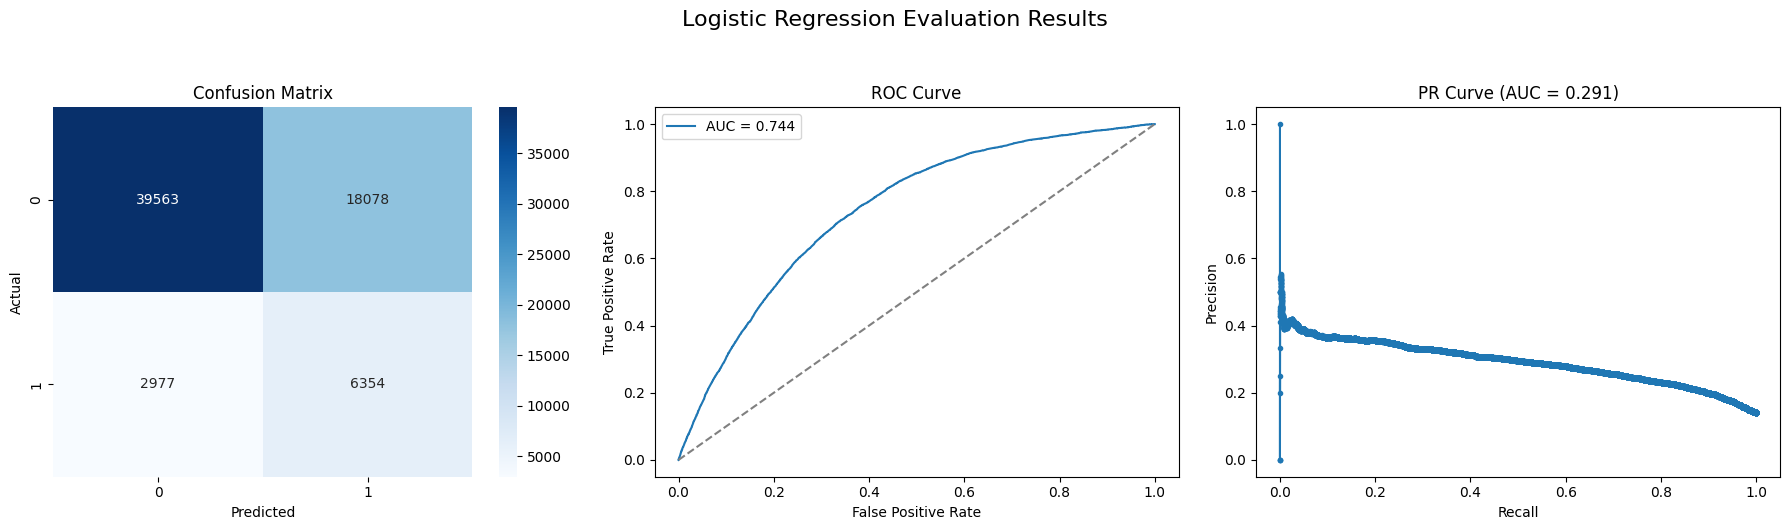

Logistic Regression Coefficients (Top 10):
              Feature  Coefficient  Odds_Ratio
4   HvyAlcoholConsump    -2.131679    0.118638
6         NoDocbcCost    -0.971082    0.378673
7             GenHlth     0.576909    1.780527
2              Fruits    -0.429809    0.650633
1        PhysActivity    -0.423035    0.655056
0              Smoker    -0.336416    0.714326
8            DiffWalk    -0.289685    0.748500
3             Veggies    -0.186766    0.829638
10                Age     0.160672    1.174300
11          Education    -0.150478    0.860297

Training LightGBM...
[LightGBM] [Info] Number of positive: 112807, number of negative: 117026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 229833, number of used featur

c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


=== LightGBM Evaluation ===
ROC-AUC:  0.746

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76     57641
           1       0.25      0.73      0.37      9331

    accuracy                           0.65     66972
   macro avg       0.59      0.69      0.57     66972
weighted avg       0.84      0.65      0.71     66972



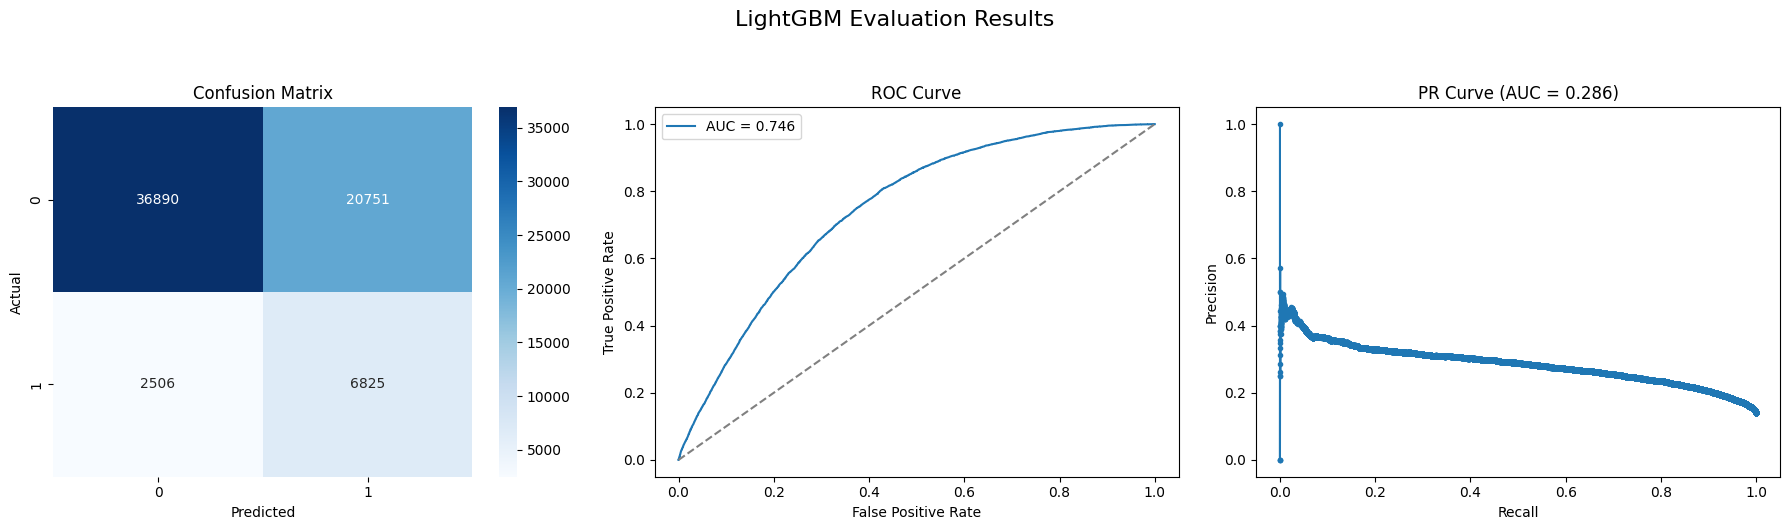

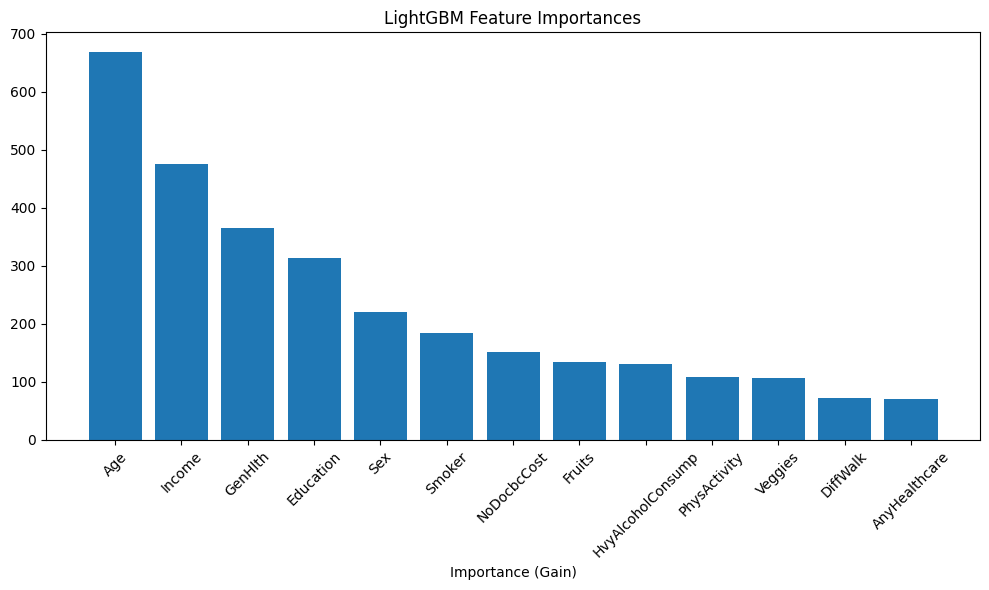


Feature Importance Values:
Age: 669.0000
Income: 475.0000
GenHlth: 365.0000
Education: 314.0000
Sex: 220.0000
Smoker: 185.0000
NoDocbcCost: 151.0000
Fruits: 134.0000
HvyAlcoholConsump: 130.0000
PhysActivity: 108.0000
Veggies: 106.0000
DiffWalk: 73.0000
AnyHealthcare: 70.0000

STATISTICAL COMPARISON OF MODELS

Random Forest vs Logistic Regression:
  F1-score (threshold=0.5): 0.322 vs 0.376
  PR-AUC: 0.246 vs 0.291
  ROC-AUC: 0.682 vs 0.744
  t-statistic (on squared probs): 3.3912, p-value: 0.0007
  Result: Logistic Regression is SIGNIFICANTLY better than Random Forest (p < 0.05)

Random Forest vs LightGBM:
  F1-score (threshold=0.5): 0.322 vs 0.370
  PR-AUC: 0.246 vs 0.286
  ROC-AUC: 0.682 vs 0.746
  t-statistic (on squared probs): 8.2085, p-value: 0.0000
  Result: LightGBM is SIGNIFICANTLY better than Random Forest (p < 0.05)

Logistic Regression vs LightGBM:
  F1-score (threshold=0.5): 0.376 vs 0.370
  PR-AUC: 0.291 vs 0.286
  ROC-AUC: 0.744 vs 0.746
  t-statistic (on squared probs):

{'feature_subset': 'lifestyle',
 'features_used': ['Smoker',
  'PhysActivity',
  'Fruits',
  'Veggies',
  'HvyAlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education',
  'Income'],
 'models': {'rf': RandomForestClassifier(class_weight='balanced', n_estimators=200,
                         random_state=42),
  'lr': LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
  'lgbm': LGBMClassifier(class_weight='balanced', random_state=42)},
 'predictions': {'rf_proba': array([0.35844531, 0.78183568, 0.        , ..., 0.        , 0.36023351,
         0.085     ], shape=(66972,)),
  'rf_pred': array([0, 1, 0, ..., 0, 0, 0], shape=(66972,)),
  'lr_proba': array([0.47607942, 0.46990258, 0.22538412, ..., 0.0941706 , 0.2090891 ,
         0.40721177], shape=(66972,)),
  'lr_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(66972,)),
  'lgbm_proba': array([0.38921524, 0.62452106, 0.08673878, ..., 0.04141427, 0.28886323,
   

In [43]:
# Test with lifestyle features only
results_lifestyle = model_select(X_train, X_val, y_train, y_val, "lifestyle")
results_lifestyle

In [44]:
results_lifestyle['comparison_results']

[{'model1': 'Random Forest',
  'model2': 'Logistic Regression',
  'f1_1': 0.3221821924858466,
  'f1_2': 0.37638835411545185,
  'pr_auc1': 0.24622213446525654,
  'pr_auc2': 0.29072763043864064,
  'roc_auc1': 0.6822202942844998,
  'roc_auc2': 0.7437209198950683,
  't_stat': np.float64(3.391224586273241),
  'p_value': np.float64(0.0006962124300234155),
  'is_significant': np.True_,
  'better_model': 'Logistic Regression'},
 {'model1': 'Random Forest',
  'model2': 'LightGBM',
  'f1_1': 0.3221821924858466,
  'f1_2': 0.36984853821768227,
  'pr_auc1': 0.24622213446525654,
  'pr_auc2': 0.2856396813132272,
  'roc_auc1': 0.6822202942844998,
  'roc_auc2': 0.7458606826795364,
  't_stat': np.float64(8.208489509769894),
  'p_value': np.float64(2.27927996231995e-16),
  'is_significant': np.True_,
  'better_model': 'LightGBM'},
 {'model1': 'Logistic Regression',
  'model2': 'LightGBM',
  'f1_1': 0.37638835411545185,
  'f1_2': 0.36984853821768227,
  'pr_auc1': 0.29072763043864064,
  'pr_auc2': 0.285639

Using MEDICAL features (10 features)
Features: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke', 'HeartDiseaseorAttack', 'Sex', 'Age', 'Education', 'Income']
Training Random Forest...


c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


=== RandomForest Evaluation ===
ROC-AUC:  0.693

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81     57641
           1       0.24      0.53      0.33      9331

    accuracy                           0.70     66972
   macro avg       0.57      0.63      0.57     66972
weighted avg       0.81      0.70      0.74     66972



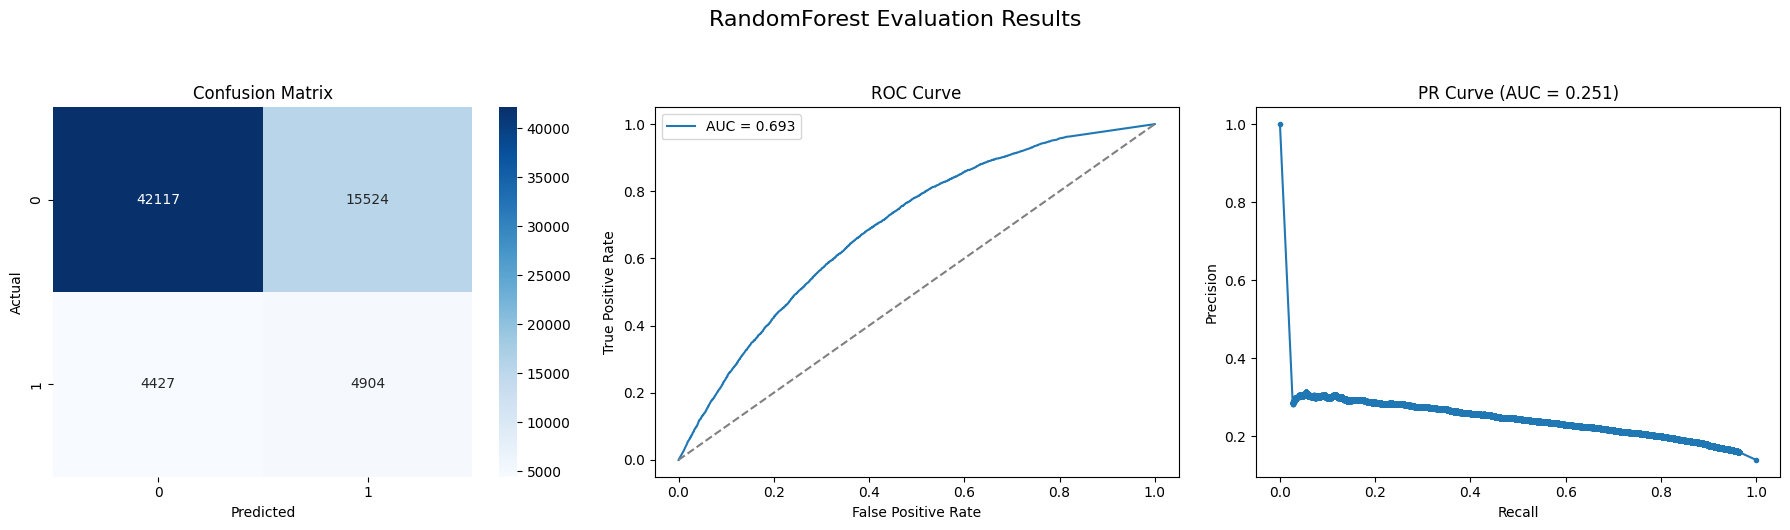

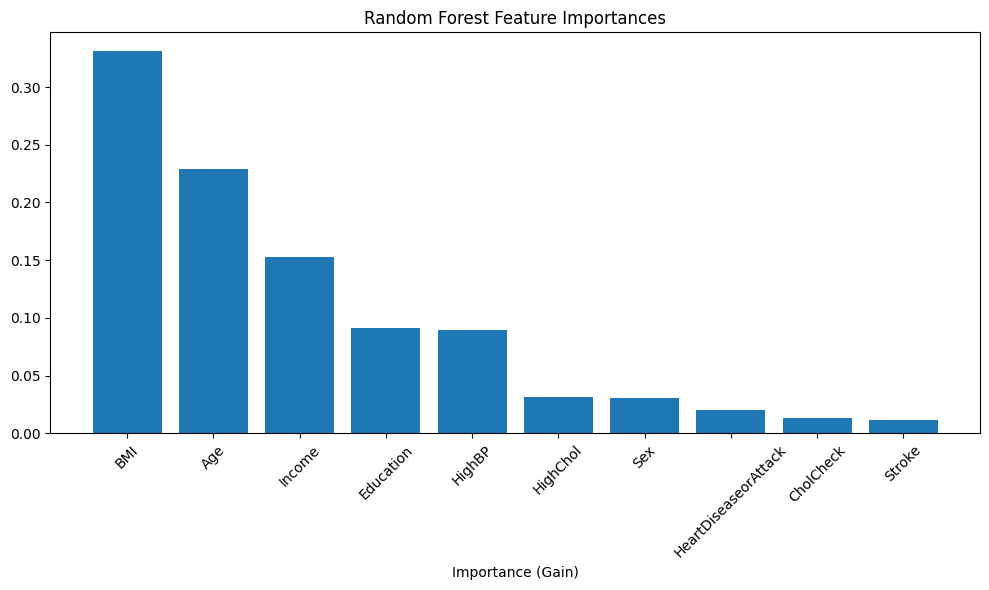


Feature Importance Values:
BMI: 0.3309
Age: 0.2294
Income: 0.1528
Education: 0.0915
HighBP: 0.0891
HighChol: 0.0311
Sex: 0.0305
HeartDiseaseorAttack: 0.0202
CholCheck: 0.0128
Stroke: 0.0118

Training Logistic Regression...


c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== Logistic Regression Evaluation ===
ROC-AUC:  0.783

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.67      0.79     57641
           1       0.27      0.76      0.40      9331

    accuracy                           0.68     66972
   macro avg       0.61      0.71      0.59     66972
weighted avg       0.85      0.68      0.73     66972



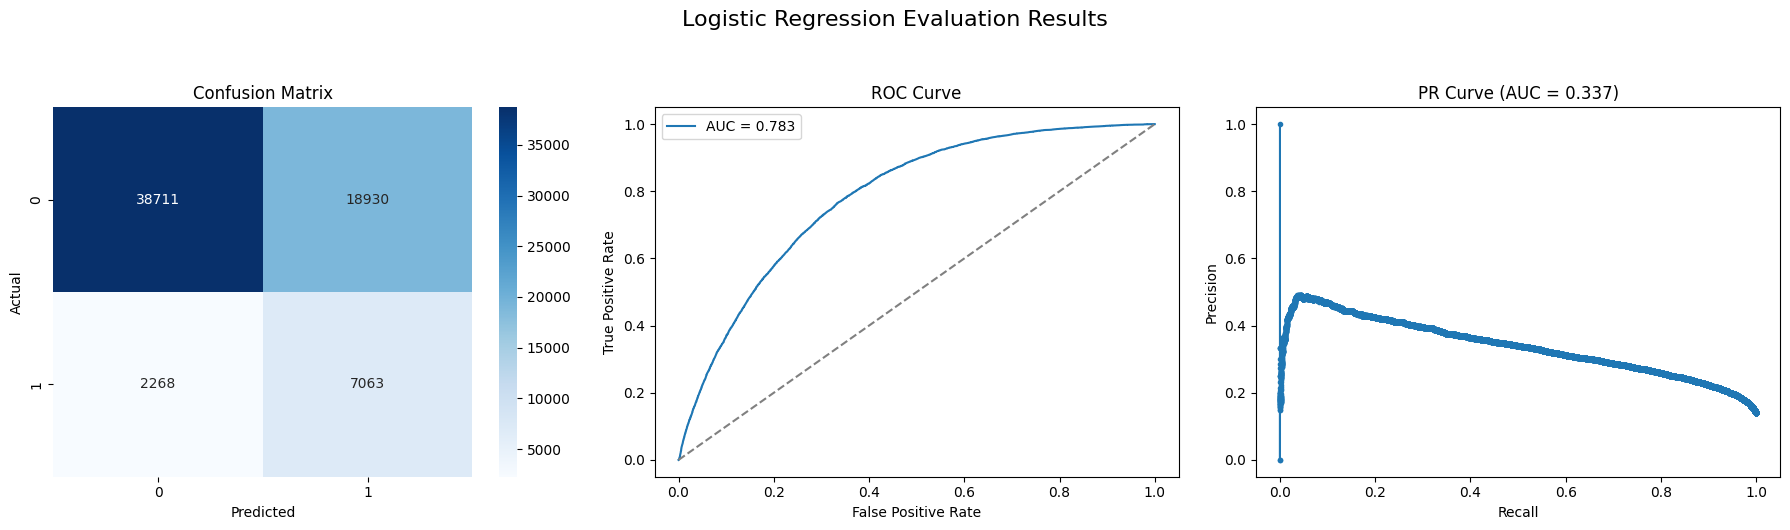

Logistic Regression Coefficients (Top 10):
                Feature  Coefficient  Odds_Ratio
2             CholCheck     1.266564    3.548637
0                HighBP     0.637652    1.892032
4                Stroke    -0.577212    0.561461
1              HighChol     0.406687    1.501834
8             Education    -0.214480    0.806961
7                   Age     0.138906    1.149016
9                Income    -0.126549    0.881131
3                   BMI     0.074156    1.076975
6                   Sex    -0.018166    0.981998
5  HeartDiseaseorAttack     0.014422    1.014526

Training LightGBM...
[LightGBM] [Info] Number of positive: 112807, number of negative: 117026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 229833, number of used features: 10
[LightGBM] [Info] [binary:BoostFro

c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


=== LightGBM Evaluation ===
ROC-AUC:  0.784

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.65      0.77     57641
           1       0.26      0.78      0.39      9331

    accuracy                           0.67     66972
   macro avg       0.61      0.71      0.58     66972
weighted avg       0.85      0.67      0.72     66972



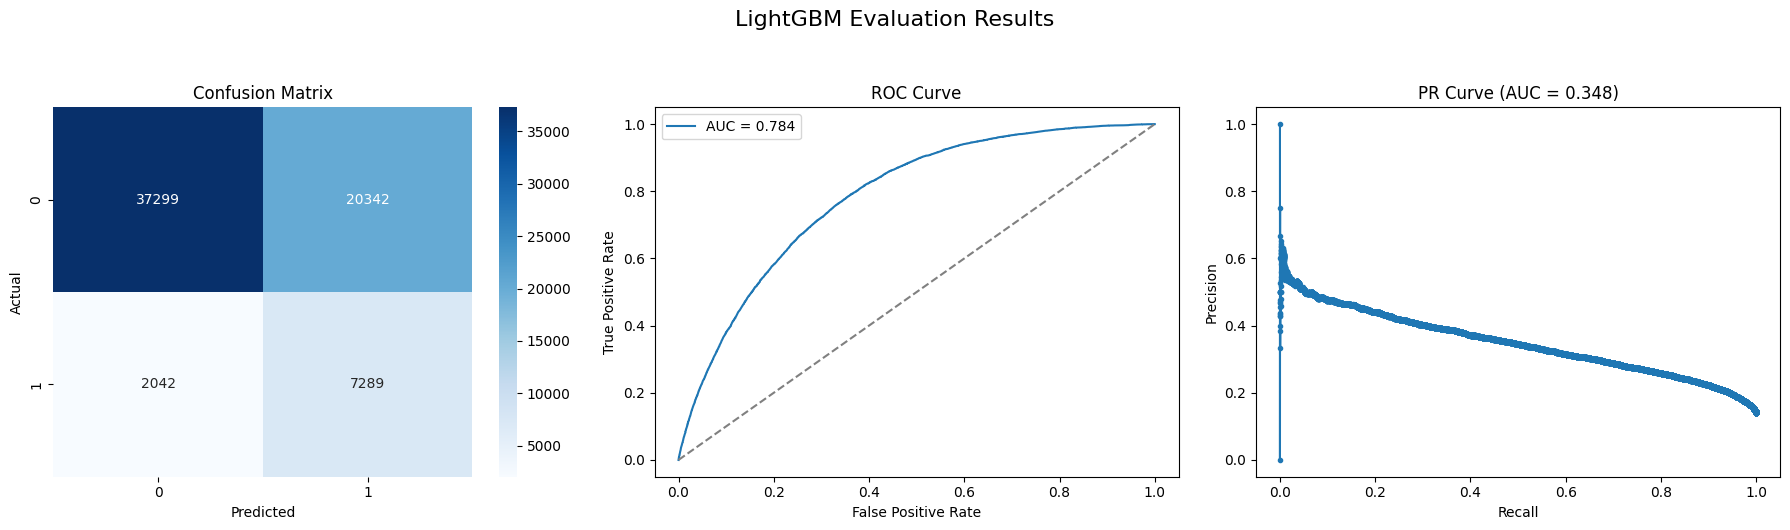

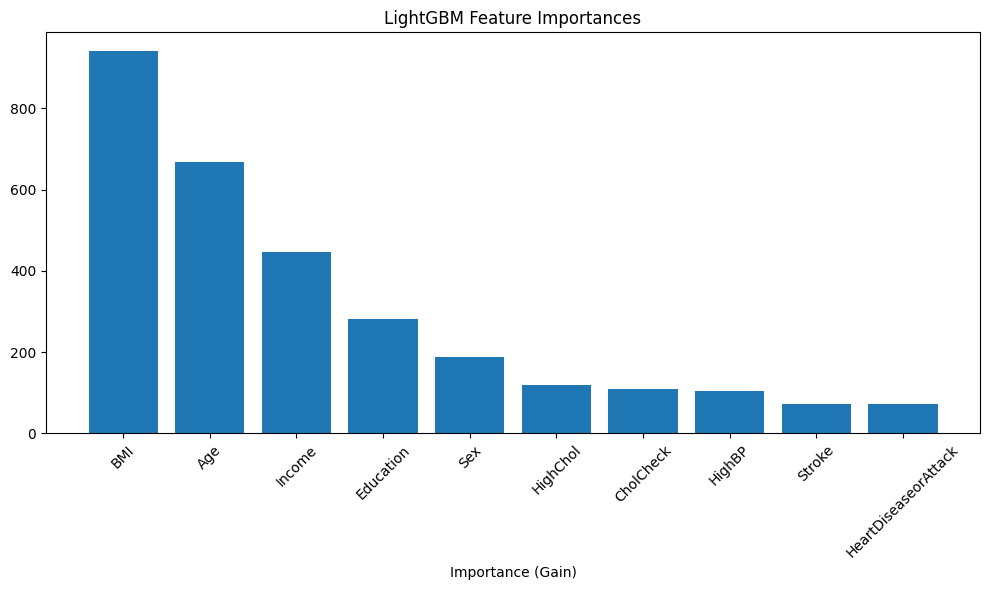


Feature Importance Values:
BMI: 940.0000
Age: 669.0000
Income: 445.0000
Education: 282.0000
Sex: 187.0000
HighChol: 120.0000
CholCheck: 108.0000
HighBP: 105.0000
Stroke: 73.0000
HeartDiseaseorAttack: 71.0000

STATISTICAL COMPARISON OF MODELS

Random Forest vs Logistic Regression:
  F1-score (threshold=0.5): 0.330 vs 0.400
  PR-AUC: 0.251 vs 0.337
  ROC-AUC: 0.693 vs 0.783
  t-statistic (on squared probs): 0.5949, p-value: 0.5519
  Result: No significant difference between models (p >= 0.05)

Random Forest vs LightGBM:
  F1-score (threshold=0.5): 0.330 vs 0.394
  PR-AUC: 0.251 vs 0.348
  ROC-AUC: 0.693 vs 0.784
  t-statistic (on squared probs): 4.3104, p-value: 0.0000
  Result: LightGBM is SIGNIFICANTLY better than Random Forest (p < 0.05)

Logistic Regression vs LightGBM:
  F1-score (threshold=0.5): 0.400 vs 0.394
  PR-AUC: 0.337 vs 0.348
  ROC-AUC: 0.783 vs 0.784
  t-statistic (on squared probs): 10.2415, p-value: 0.0000
  Result: Logistic Regression is SIGNIFICANTLY better than Ligh

{'feature_subset': 'medical',
 'features_used': ['HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'Stroke',
  'HeartDiseaseorAttack',
  'Sex',
  'Age',
  'Education',
  'Income'],
 'models': {'rf': RandomForestClassifier(class_weight='balanced', n_estimators=200,
                         random_state=42),
  'lr': LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
  'lgbm': LGBMClassifier(class_weight='balanced', random_state=42)},
 'predictions': {'rf_proba': array([0.11624255, 0.78365929, 0.        , ..., 0.10074361, 0.48864933,
         0.00704422], shape=(66972,)),
  'rf_pred': array([0, 1, 0, ..., 0, 0, 0], shape=(66972,)),
  'lr_proba': array([0.57812244, 0.59953615, 0.12937027, ..., 0.14554758, 0.49077658,
         0.22521283], shape=(66972,)),
  'lr_pred': array([1, 1, 0, ..., 0, 0, 0], shape=(66972,)),
  'lgbm_proba': array([0.40681456, 0.65119473, 0.03872578, ..., 0.11137649, 0.39465202,
         0.1263027 ], shape=(66972,)),
  'lgbm_pred': arra

In [45]:
# Test with medical features only  
results_medical = model_select(X_train, X_val, y_train, y_val, "medical")
results_medical

In [46]:
results_medical['comparison_results']

[{'model1': 'Random Forest',
  'model2': 'Logistic Regression',
  'f1_1': 0.3296489165126827,
  'f1_2': 0.39989808628694373,
  'pr_auc1': 0.2505148541319443,
  'pr_auc2': 0.33696193519522405,
  'roc_auc1': 0.6928900089166614,
  'roc_auc2': 0.7832102556317888,
  't_stat': np.float64(0.5948816459993626),
  'p_value': np.float64(0.5519245965268809),
  'is_significant': np.False_,
  'better_model': 'Logistic Regression'},
 {'model1': 'Random Forest',
  'model2': 'LightGBM',
  'f1_1': 0.3296489165126827,
  'f1_2': 0.39440506466100317,
  'pr_auc1': 0.2505148541319443,
  'pr_auc2': 0.3478736235411428,
  'roc_auc1': 0.6928900089166614,
  'roc_auc2': 0.784003724909943,
  't_stat': np.float64(4.310444630625643),
  'p_value': np.float64(1.6315888205716196e-05),
  'is_significant': np.True_,
  'better_model': 'LightGBM'},
 {'model1': 'Logistic Regression',
  'model2': 'LightGBM',
  'f1_1': 0.39989808628694373,
  'f1_2': 0.39440506466100317,
  'pr_auc1': 0.33696193519522405,
  'pr_auc2': 0.34787362

Using ALL features (19 features)
Features: ['GenHlth', 'DiffWalk', 'NoDocbcCost', 'HvyAlcoholConsump', 'CholCheck', 'Education', 'PhysActivity', 'HeartDiseaseorAttack', 'Fruits', 'Stroke', 'Sex', 'Income', 'Smoker', 'Veggies', 'HighBP', 'AnyHealthcare', 'Age', 'BMI', 'HighChol']
Training Random Forest...


c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


=== RandomForest Evaluation ===
ROC-AUC:  0.760

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87     57641
           1       0.31      0.48      0.37      9331

    accuracy                           0.78     66972
   macro avg       0.61      0.65      0.62     66972
weighted avg       0.82      0.78      0.80     66972



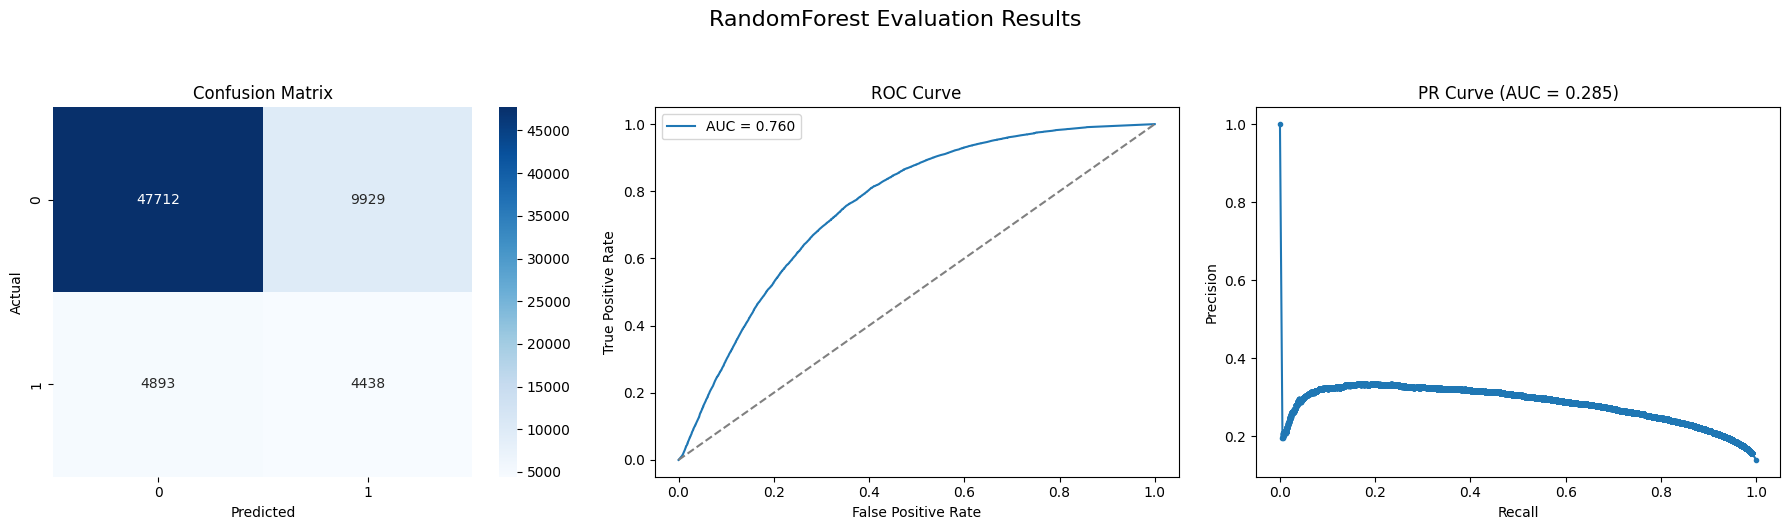

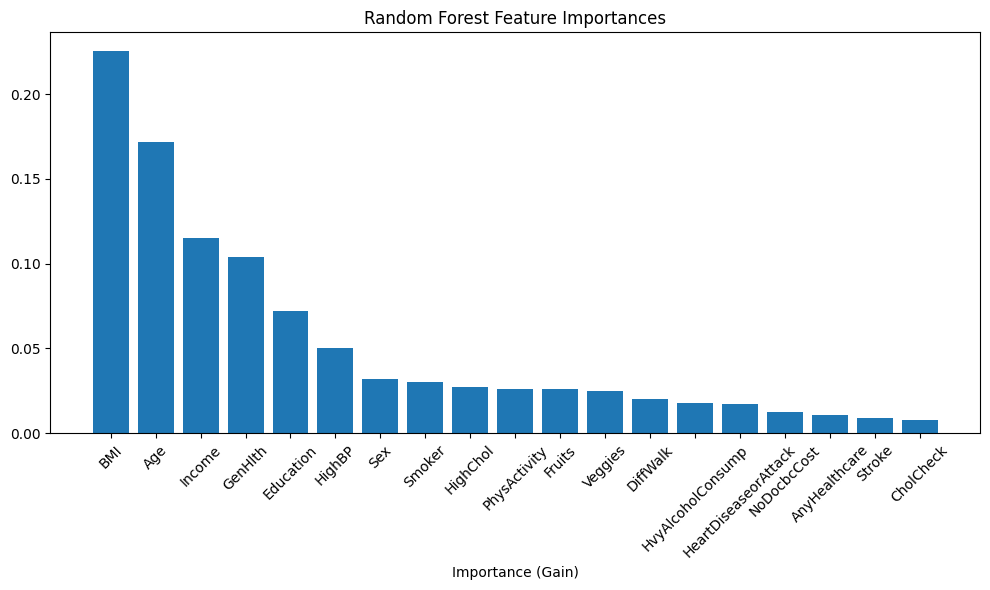


Feature Importance Values:
BMI: 0.2252
Age: 0.1718
Income: 0.1152
GenHlth: 0.1042
Education: 0.0718
HighBP: 0.0500
Sex: 0.0321
Smoker: 0.0300
HighChol: 0.0274
PhysActivity: 0.0264
Fruits: 0.0259
Veggies: 0.0249
DiffWalk: 0.0204
HvyAlcoholConsump: 0.0179
HeartDiseaseorAttack: 0.0171
NoDocbcCost: 0.0128
AnyHealthcare: 0.0106
Stroke: 0.0087
CholCheck: 0.0076

Training Logistic Regression...


c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== Logistic Regression Evaluation ===
ROC-AUC:  0.787

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.70      0.80     57641
           1       0.28      0.73      0.41      9331

    accuracy                           0.70     66972
   macro avg       0.61      0.71      0.60     66972
weighted avg       0.85      0.70      0.75     66972



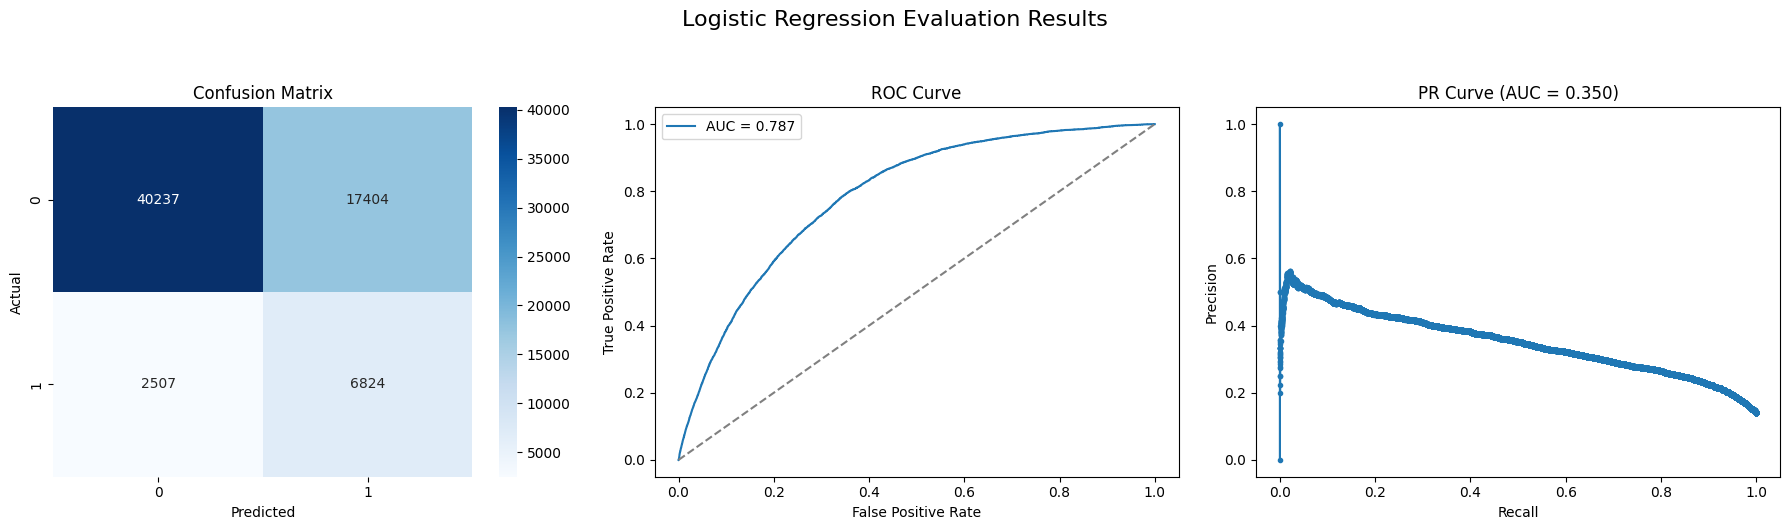

Logistic Regression Coefficients (Top 10):
              Feature  Coefficient  Odds_Ratio
3   HvyAlcoholConsump    -2.106183    0.121702
4           CholCheck     1.221239    3.391389
2         NoDocbcCost    -0.967923    0.379871
9              Stroke    -0.664436    0.514564
14             HighBP     0.568945    1.766402
0             GenHlth     0.483581    1.621871
1            DiffWalk    -0.438669    0.644894
8              Fruits    -0.371662    0.689587
6        PhysActivity    -0.354167    0.701758
18           HighChol     0.353886    1.424593

Training LightGBM...


c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ignasius.dwi\Downloads\Github\class-diabetes-lifestyle\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 112807, number of negative: 117026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 229833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
=== LightGBM Evaluation ===
ROC-AUC:  0.790

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.67      0.79     57641
           1       0.28      0.76      0.40      9331

    accuracy                           0.69     66972
   macro avg       0.61      0.72      0.60     66972
weighted avg       0.85      0.69      0.73     66972



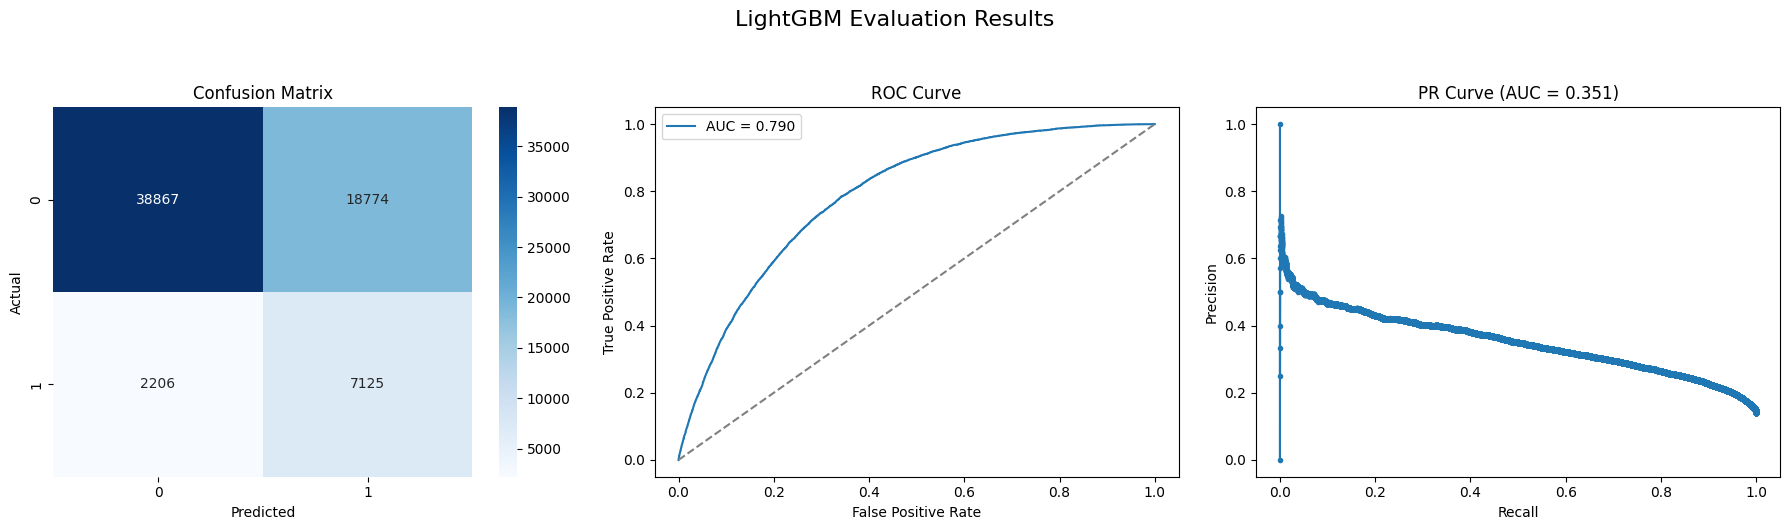

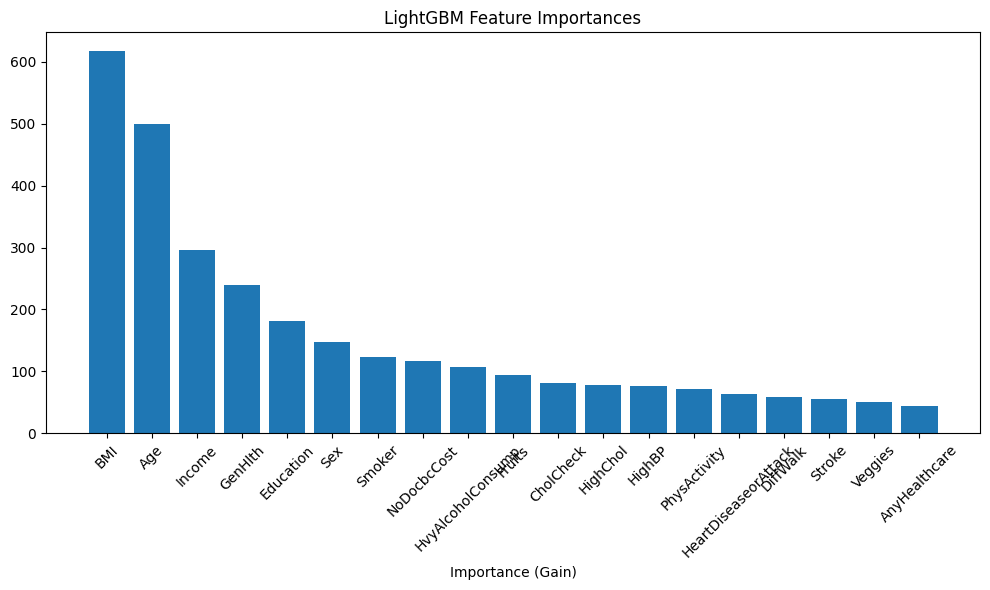


Feature Importance Values:
BMI: 617.0000
Age: 499.0000
Income: 296.0000
GenHlth: 239.0000
Education: 181.0000
Sex: 148.0000
Smoker: 123.0000
NoDocbcCost: 116.0000
HvyAlcoholConsump: 107.0000
Fruits: 94.0000
CholCheck: 81.0000
HighChol: 78.0000
HighBP: 77.0000
PhysActivity: 72.0000
HeartDiseaseorAttack: 63.0000
DiffWalk: 59.0000
Stroke: 55.0000
Veggies: 51.0000
AnyHealthcare: 44.0000

STATISTICAL COMPARISON OF MODELS

Random Forest vs Logistic Regression:
  F1-score (threshold=0.5): 0.375 vs 0.407
  PR-AUC: 0.285 vs 0.350
  ROC-AUC: 0.760 vs 0.787
  t-statistic (on squared probs): -54.5509, p-value: 0.0000
  Result: Logistic Regression is SIGNIFICANTLY better than Random Forest (p < 0.05)

Random Forest vs LightGBM:
  F1-score (threshold=0.5): 0.375 vs 0.404
  PR-AUC: 0.285 vs 0.351
  ROC-AUC: 0.760 vs 0.790
  t-statistic (on squared probs): -52.5371, p-value: 0.0000
  Result: LightGBM is SIGNIFICANTLY better than Random Forest (p < 0.05)

Logistic Regression vs LightGBM:
  F1-score (t

{'feature_subset': 'all',
 'features_used': ['GenHlth',
  'DiffWalk',
  'NoDocbcCost',
  'HvyAlcoholConsump',
  'CholCheck',
  'Education',
  'PhysActivity',
  'HeartDiseaseorAttack',
  'Fruits',
  'Stroke',
  'Sex',
  'Income',
  'Smoker',
  'Veggies',
  'HighBP',
  'AnyHealthcare',
  'Age',
  'BMI',
  'HighChol'],
 'models': {'rf': RandomForestClassifier(class_weight='balanced', n_estimators=200,
                         random_state=42),
  'lr': LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
  'lgbm': LGBMClassifier(class_weight='balanced', random_state=42)},
 'predictions': {'rf_proba': array([0.02621128, 0.31630972, 0.02080797, ..., 0.00770466, 0.10336225,
         0.045     ], shape=(66972,)),
  'rf_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(66972,)),
  'lr_proba': array([0.54595536, 0.51750972, 0.1810297 , ..., 0.05470171, 0.2780053 ,
         0.33307833], shape=(66972,)),
  'lr_pred': array([1, 1, 0, ..., 0, 0, 0], shape=(66972,)),
  'lgbm_p

In [47]:
# Test with all features (your original baseline)
results_all = model_select(X_train, X_val, y_train, y_val, "all")
results_all

In [48]:
results_all['comparison_results']

[{'model1': 'Random Forest',
  'model2': 'Logistic Regression',
  'f1_1': 0.3754667114150271,
  'f1_2': 0.4066867308322656,
  'pr_auc1': 0.28498790677433355,
  'pr_auc2': 0.34973818752259955,
  'roc_auc1': 0.759580341679734,
  'roc_auc2': 0.7866779284817909,
  't_stat': np.float64(-54.55093265893183),
  'p_value': np.float64(0.0),
  'is_significant': np.True_,
  'better_model': 'Logistic Regression'},
 {'model1': 'Random Forest',
  'model2': 'LightGBM',
  'f1_1': 0.3754667114150271,
  'f1_2': 0.40448481407891,
  'pr_auc1': 0.28498790677433355,
  'pr_auc2': 0.3508779909195225,
  'roc_auc1': 0.759580341679734,
  'roc_auc2': 0.789725572944265,
  't_stat': np.float64(-52.53711071961672),
  'p_value': np.float64(0.0),
  'is_significant': np.True_,
  'better_model': 'LightGBM'},
 {'model1': 'Logistic Regression',
  'model2': 'LightGBM',
  'f1_1': 0.4066867308322656,
  'f1_2': 0.40448481407891,
  'pr_auc1': 0.34973818752259955,
  'pr_auc2': 0.3508779909195225,
  'roc_auc1': 0.7866779284817909

### **Conclusion:**

- Although we reduce the features into lifestyle only, the ROC-AUC scores are still above 0.65 for all models and could still be considered as "acceptable". In terms of ROC-AUC score, LightGBM is slightly better than Logistic Regression.
- Tree-based often give overconfident probabilities, thus can be fixed with some calibration techniques. So, even if ROC-AUC of logistic regression is slightly lower than LightGBM, its probability estimates (the “risk %” you show in your app) are closer to reality.
- In terms of F1-score, all the subset of features are around 0.4.
- In terms of PR-AUC score, all models are about 0.3, a way above 0.14 (natural prevalence from the dataset).
- Therefore, we conclude that the logistic regresion model with the subset of lifestyle features is still "acceptable" to predict the target class.

## Nested CV to get actual performance

In [49]:
def feature_selection_by_performance(X_train, y_train, X_val, y_val, feature_order, 
                                   pr_auc_threshold=0.7, roc_auc_threshold=0.8, random_state=42):
    """
    Perform feature selection based on performance thresholds
    """
    subset = []
    
    for feature in feature_order:
        subset.append(feature)
        X_train_small = X_train[subset]
        X_val_small = X_val[subset]
        
        lr_small = LogisticRegression(solver='liblinear', random_state=random_state, 
                                    class_weight='balanced')
        lr_small.fit(X_train_small, y_train)
        y_proba_lr_small = lr_small.predict_proba(X_val_small)[:, 1]
        
        precision, recall, _ = precision_recall_curve(y_val, y_proba_lr_small)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(y_val, y_proba_lr_small)
        
        if (pr_auc >= pr_auc_threshold) or (roc_auc >= roc_auc_threshold):
            print(f'Selected features: {subset}')
            print(f'PR_AUC: {pr_auc:.3f}, ROC_AUC: {roc_auc:.3f}')
            return subset
    
    # If no subset meets criteria, return all features
    print(f'No subset met criteria, using all features: {feature_order}')
    return feature_order

In [50]:
def nested_cv_with_threshold(X, y, feature_order, outer_splits=3, inner_splits=5, 
                           param_grid=None, pr_auc_threshold=0.7, roc_auc_threshold=0.8,
                           random_state=42, save_path=None):
    """
    Nested CV with feature selection inside each fold
    """
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    outer_scores = []
    best_models = []
    selected_features_per_fold = []
    best_thresholds_per_fold = []
    best_params_per_fold = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        print(f"\n=== Outer Fold {fold + 1} ===")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Further split training data for feature selection
        inner_train_size = int(0.8 * len(X_train))
        X_fs_train = X_train.iloc[:inner_train_size]
        y_fs_train = y_train.iloc[:inner_train_size]
        X_fs_val = X_train.iloc[inner_train_size:]
        y_fs_val = y_train.iloc[inner_train_size:]
        
        # Feature selection for this fold
        selected_features = feature_selection_by_performance(
            X_fs_train, y_fs_train, X_fs_val, y_fs_val, 
            feature_order, pr_auc_threshold, roc_auc_threshold, random_state
        )
        selected_features_per_fold.append(selected_features)
        
        # Use only selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        clf = LogisticRegression(solver='liblinear', random_state=random_state, 
                               class_weight='balanced')
        
        grid_search = GridSearchCV(clf, param_grid=param_grid, cv=inner_cv, 
                                 scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_selected, y_train)
        
        best_model = grid_search.best_estimator_
        best_models.append(best_model)
        best_params_per_fold.append(grid_search.best_params_)
        
        # Threshold optimization using a portion of training data
        threshold_train_size = int(0.7 * len(X_train_selected))
        X_thresh_train = X_train_selected.iloc[:threshold_train_size]
        y_thresh_train = y_train.iloc[:threshold_train_size]
        X_thresh_val = X_train_selected.iloc[threshold_train_size:]
        y_thresh_val = y_train.iloc[threshold_train_size:]
        
        # Fit model on threshold training data
        best_model.fit(X_thresh_train, y_thresh_train)
        y_proba_thresh = best_model.predict_proba(X_thresh_val)[:, 1]
        
        # Optimize threshold
        precision, recall, thresholds = precision_recall_curve(y_thresh_val, y_proba_thresh)
        
        # Handle edge case where thresholds array might be shorter
        if len(thresholds) > 1:
            f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
            if len(f1_scores) > 0:
                best_idx = np.argmax(f1_scores)
                best_threshold = thresholds[best_idx]
            else:
                best_threshold = 0.5
        else:
            best_threshold = 0.5
            
        best_thresholds_per_fold.append(best_threshold)
        
        # Final evaluation on test set
        best_model.fit(X_train_selected, y_train) 
        y_proba_test = best_model.predict_proba(X_test_selected)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba_test)
        outer_scores.append(roc_auc)
        
        # Calculate test metrics with optimized threshold
        y_pred_test = (y_proba_test >= best_threshold).astype(int)
        test_f1 = f1_score(y_test, y_pred_test)
        
        print(f"Fold {fold + 1} - Selected features: {len(selected_features)}")
        print(f"Fold {fold + 1} - Best params: {grid_search.best_params_}")
        print(f"Fold {fold + 1} - Best threshold: {best_threshold:.3f}")
        print(f"Fold {fold + 1} - ROC-AUC: {roc_auc:.3f}")
        print(f"Fold {fold + 1} - F1-score: {test_f1:.3f}")
    
    mean_roc_auc = np.mean(outer_scores)
    std_roc_auc = np.std(outer_scores)
    
    print(f"\n=== Results ===")
    print(f"Nested CV mean ROC-AUC: {mean_roc_auc:.3f} ± {std_roc_auc:.3f}")
    
    # Determine final features (most commonly selected)
    all_features = [f for fold_features in selected_features_per_fold for f in fold_features]
    feature_counts = Counter(all_features)
    
    # Use features that appear in at least half the folds
    min_count = max(1, len(selected_features_per_fold) // 2)
    final_features = [f for f, count in feature_counts.items() if count >= min_count]
    
    if not final_features:  # Fallback
        final_features = list(feature_counts.most_common(10))  # Top 10 most common
        final_features = [f[0] for f in final_features]
    
    print(f"Final model features ({len(final_features)}): {final_features}")
    
    # Determine best hyperparameters (most common)
    param_keys = best_params_per_fold[0].keys()
    best_params_final = {}
    
    for key in param_keys:
        param_values = [params[key] for params in best_params_per_fold]
        param_counts = Counter(param_values)
        best_params_final[key] = param_counts.most_common(1)[0][0]
    
    print(f"Final model parameters: {best_params_final}")
    
    # Train final model on full dataset
    X_final = X[final_features]
    final_model = LogisticRegression(solver='liblinear', random_state=random_state, 
                                   class_weight='balanced')
    final_model.set_params(**best_params_final)
    final_model.fit(X_final, y)
    
    # Use median threshold across folds
    final_threshold = np.median(best_thresholds_per_fold)
    
    # Save model if path provided
    if save_path is not None:
        MODEL_DIR = "model/"
        if not os.path.exists(MODEL_DIR):
            os.makedirs(MODEL_DIR)
        save_path = os.path.join(MODEL_DIR, save_path)
            
    model_dict = {
        'model': final_model,
        'selected_features': final_features,
        'threshold': final_threshold,
        'parameters': best_params_final,
        'cv_results': {
            'mean_roc_auc': mean_roc_auc,
            'std_roc_auc': std_roc_auc,
            'fold_scores': outer_scores,
            'fold_features': selected_features_per_fold,
            'fold_thresholds': best_thresholds_per_fold,
            'fold_params': best_params_per_fold
        }
    }

    # Save using joblib (recommended for sklearn models)
    deploy_dict = {
    "model": final_model,
    "features": final_features,
    "threshold": final_threshold
    }
    
    # Save for deployment
    joblib.dump(deploy_dict, f"{save_path}.pkl")
    print(f"Model saved to {save_path}")

    # Save for backup
    joblib.dump(model_dict, f"{save_path}_full.pkl")
    print(f"Model saved to {save_path}")
        
    return {
        'final_model': final_model,
        'selected_features': final_features,
        'best_threshold': final_threshold,
        'best_parameters': best_params_final,
        'mean_roc_auc': mean_roc_auc,
        'std_roc_auc': std_roc_auc,
        'fold_scores': outer_scores,
        'fold_features': selected_features_per_fold,
        'fold_thresholds': best_thresholds_per_fold,
        'fold_params': best_params_per_fold
    }

In [51]:
feat = ['Age', 'Income', 'GenHlth', 'Education', 'Sex', 'Smoker', 'Fruits', 'NoDocbcCost',
        'HvyAlcoholConsump', 'PhysActivity', 'Veggies','AnyHealthcare', 'DiffWalk']
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1','l2']}
pr_auc_threshold = 0.7
roc_auc_threshold = 0.8

X_train_np = pd.DataFrame(X_train, columns=X_train.columns)
X_val_np   = pd.DataFrame(X_val, columns=X_val.columns)
X_test_np  = pd.DataFrame(X_test, columns=X_test.columns)

y_train_np = pd.Series(np.ravel(y_train))
y_val_np   = pd.Series(np.ravel(y_val))
y_test_np  = pd.Series(np.ravel(y_test))

# Concatenate everything back together
X_full = pd.concat([X_train_np, X_val_np, X_test_np], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train_np, y_val_np, y_test_np], axis=0).reset_index(drop=True)


results = nested_cv_with_threshold(
    X=X_full,
    y=y_full,
    feature_order=feat,
    param_grid=param_grid,
    pr_auc_threshold=pr_auc_threshold,
    roc_auc_threshold=roc_auc_threshold,
    random_state=RSEED,
    save_path="diabetes_class"  # This will save the model
)

print(f"\nFinal Results:")
print(f"Mean ROC-AUC: {results['mean_roc_auc']:.3f} ± {results['std_roc_auc']:.3f}")
print(f"Selected Features: {results['selected_features']}")
print(f"Best Parameters: {results['best_parameters']}")
print(f"Optimal Threshold: {results['best_threshold']:.3f}")


=== Outer Fold 1 ===
No subset met criteria, using all features: ['Age', 'Income', 'GenHlth', 'Education', 'Sex', 'Smoker', 'Fruits', 'NoDocbcCost', 'HvyAlcoholConsump', 'PhysActivity', 'Veggies', 'AnyHealthcare', 'DiffWalk']
Fold 1 - Selected features: 13
Fold 1 - Best params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 - Best threshold: 0.548
Fold 1 - ROC-AUC: 0.758
Fold 1 - F1-score: 0.599

=== Outer Fold 2 ===
No subset met criteria, using all features: ['Age', 'Income', 'GenHlth', 'Education', 'Sex', 'Smoker', 'Fruits', 'NoDocbcCost', 'HvyAlcoholConsump', 'PhysActivity', 'Veggies', 'AnyHealthcare', 'DiffWalk']
Fold 2 - Selected features: 13
Fold 2 - Best params: {'C': 0.01, 'penalty': 'l1'}
Fold 2 - Best threshold: 0.547
Fold 2 - ROC-AUC: 0.760
Fold 2 - F1-score: 0.601

=== Outer Fold 3 ===
No subset met criteria, using all features: ['Age', 'Income', 'GenHlth', 'Education', 'Sex', 'Smoker', 'Fruits', 'NoDocbcCost', 'HvyAlcoholConsump', 'PhysActivity', 'Veggies', 'AnyHealthcare', 'DiffWa

In [52]:
# Load the model
try:
    file_path = "model/diabetes_class.pkl"
    model_dict = joblib.load(file_path)
    print(f"Model loaded from {file_path}")
    model_dict
except Exception as e:
    raise FileNotFoundError("Model is not found")

Model loaded from model/diabetes_class.pkl
